In [3]:
import glob
from prody import *
import pandas as pd
import re
import numpy as np
import tqdm
import natsort
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import py3Dmol
import networkx as nx

In [4]:
# Limits of p values:
# We do that because some p values can be reported to be zero.
np.finfo('float')

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

# HLA-B39 Simulation Analysis Pipeline

## 1. Data Preparation and Annotation
This section loads molecular dynamics simulation data from gRINN output files and prepares the interaction energy dataset.

In [3]:
BASE_FOLDER = '/mnt/MORIA/experiments/hla_b39/2022_10_14_bioe_leviathan_backup/T1DM_B39_traj_analysis/gmx_traj_data/'
grinn_outs = glob.glob(BASE_FOLDER+'*/grinn_output_skip10/energies_intEnVdW.csv')
dry_pdbs = glob.glob(BASE_FOLDER+'*/grinn_output_skip10/system_dry.pdb')

### Load simulation files
Collect gRINN energy output files and corresponding PDB structures from all HLA-B39 trajectory analyses.

In [4]:
grinn_outs = [out for out in grinn_outs if 'B3801_ALL_2' not in out]

In [5]:
dry_pdbs = [pdb for pdb in dry_pdbs if 'B3801_ALL_2' not in pdb]

### Exclude problematic trajectories and process interaction energies
Remove B3801_ALL_2 simulation (problematic trajectory) and parse interaction energy data with metadata.

In [19]:
zipped = zip(dry_pdbs, grinn_outs)
df_list = list()

# Define the theoretical frame columns
frame_cols = list(map(str,np.arange(0, 251, 1)))

for zipd in list(zipped):
    dry_pdb = zipd[0]
    matches = re.search('.*gmx_traj_data/(B\d+)(?:_([^/]*?))?_(\d+)/grinn_output_skip10/',dry_pdb)
    if matches:
        allele = matches.groups()[0]
        peptide = matches.groups()[1] if matches.groups()[1] else ''
        replica = int(matches.groups()[2])

    df_intEn = pd.read_csv(zipd[1])
    
    # Check which frame columns actually exist in the CSV
    available_frame_cols = [col for col in frame_cols if col in df_intEn.columns]
    
    df_intEn['repeat'] = replica
    df_intEn['allele'] = allele
    df_intEn['peptide'] = peptide
    df_intEn['system'] = allele + '_' + peptide if peptide else allele
    df_intEn['dry_pdb_file'] = dry_pdb

    # Use only the available frame columns
    cols_to_select = ['Pair_indices','repeat','allele','peptide','dry_pdb_file','system'] + available_frame_cols
    df_intEn = df_intEn[cols_to_select]
    
    # Change column names from "Unnamed: 0" to "pair"
    df_intEn.rename({'Pair_indices': 'pair'}, axis=1, inplace=True)

    # Limit to 377 columns as originally intended, but only if we have that many
    max_cols = min(377, len(df_intEn.columns))
    df_intEn = df_intEn[df_intEn.columns[:max_cols]]
    
    df_list.append(df_intEn)

df_intEn = pd.concat(df_list)

In [20]:
df_intEn.dropna(axis=1, inplace=True)

In [21]:
df_intEn.to_csv('intEnVdW_2025_07_10.csv')

## 2. Interaction Energy Data Processing
Add residue numbering and chain information to interaction pairs for structural analysis.

In [5]:
df_intEn = pd.read_csv('intEnVdW_2025_07_10.csv')

/tmp/ipykernel_130328/2967819015.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_intEn = pd.read_csv('intEnVdW_2025_07_10.csv')


In [7]:
dry_pdb_file = ''

for row in tqdm.tqdm(df_intEn.iterrows()):
    pair = row[1]['pair']
    dry_pdb_file_row = row[1]['dry_pdb_file']
    if dry_pdb_file_row != dry_pdb_file:
        syst_dry = parsePDB(dry_pdb_file_row)
        dry_pdb_file = dry_pdb_file_row
    
    pairs = pair.split('-')
    pair1 = syst_dry.select(f'resindex {pairs[0]}')
    pair2 = syst_dry.select(f'resindex {pairs[1]}')
    resnum1 = pair1.getResnums()[0]
    resnum2 = pair2.getResnums()[0]
    chain1 = pair1.getChids()[0]
    chain2 = pair2.getChids()[0]
    df_intEn.loc[row[0],'resnum1'] = resnum1
    df_intEn.loc[row[0],'chain1'] = chain1
    df_intEn.loc[row[0],'resnum2'] = resnum2
    df_intEn.loc[row[0],'chain2'] = chain2
    resnum_chain1 = f'{resnum1}{chain1}'
    resnum_chain2 = f'{resnum2}{chain2}'
    resnum_chain12 = [resnum_chain1,resnum_chain2]
    resnum_chain12 = natsort.natsorted(resnum_chain12)
    resnum_chain12 = '-'.join(resnum_chain12)
    df_intEn.loc[row[0],'resnum_chain1'] = resnum_chain1
    df_intEn.loc[row[0],'resnum_chain2'] = resnum_chain2
    df_intEn.loc[row[0],'resnum_chain12'] = resnum_chain12

0it [00:00, ?it/s]@> 5954 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 5954 atoms and 1 coordinate set(s) were parsed in 0.06s.
3046it [00:03, 1450.99it/s]@> 6131 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 6131 atoms and 1 coordinate set(s) were parsed in 0.07s.
6267it [00:05, 1447.74it/s]@> 6136 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 6136 atoms and 1 coordinate set(s) were parsed in 0.05s.
9439it [00:08, 1433.08it/s]@> 6136 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 6136 atoms and 1 coordinate set(s) were parsed in 0.05s.
12758it [00:10, 1403.98it/s]@> 6136 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 6136 atoms and 1 coordinate set(s) were parsed in 0.05s.
15990it [00:13, 1470.86it/s]@> 6136 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 6136 atoms and 1 coordinate set(s) were parsed in 0.05s.
19170it [00:15, 1398.76it/s]@> 6117 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 6117 atoms and 1 coordinate set(s)

## 3. Statistical Analysis of Interaction Pairs

### Identify consistent interaction pairs across replicas
Find residue pairs that show stable interactions across simulation replicates using ANOVA (p > 0.05).

In [8]:
uniq_pairs = df_intEn['resnum_chain12'].unique()

consistent_pairs = list()
other_pairs = list()

p_values_cons = list()
p_values_other = list()

for pair in tqdm.tqdm(uniq_pairs):
    df_intEn_pair = df_intEn[df_intEn['resnum_chain12']==pair].copy()

    resnum1 = df_intEn_pair['resnum1'].unique()[0]
    resnum2 = df_intEn_pair['resnum2'].unique()[0]
    chain1 = df_intEn_pair['chain1'].unique()[0]
    chain2 = df_intEn_pair['chain2'].unique()[0]

    if chain1 == chain2 and np.abs(resnum1-resnum2) < 4:
        # Don't take pairs that are too close along the covalently-bonded polypeptide chain into account.
        continue

    systems = df_intEn_pair['system'].unique()
    for system in systems:
        df_intEn_pair_system = df_intEn_pair[df_intEn_pair['system'] == system].copy()
        if not len(df_intEn_pair_system) in [3,4]:
            # Then we exclude this pair, it was not observed in at least two repeats 
            continue
        
        # Remove columns and prepare data
        columns_to_drop = ['Unnamed: 0','dry_pdb_file','system','pair','resnum1','chain1','resnum2','chain2',
                          'resnum_chain1','resnum_chain2','resnum_chain12','repeat','allele','peptide']
        
        # Only drop columns that actually exist
        columns_to_drop = [col for col in columns_to_drop if col in df_intEn_pair_system.columns]
        df_intEn_pair_system.drop(columns_to_drop, axis=1, inplace=True)
        
        # Check if we have any data left
        if df_intEn_pair_system.empty or df_intEn_pair_system.shape[1] == 0:
            continue
            
        df_values = df_intEn_pair_system.T
        
        # Check if we have enough replicates (rows) for comparison
        if len(df_values.columns) < 2:
            continue
            
        df_values.columns = np.arange(len(df_values.columns))

        # Calculate means for each replicate
        means = []
        for i in range(len(df_values.columns)):
            col_data = df_values[i].dropna()  # Remove NaN values
            if len(col_data) > 0:
                means.append(np.abs(np.mean(col_data)))
            else:
                means.append(0)
        
        means = np.array(means)
        
        if np.all(means > 0.8):
            try:
                # Prepare data for ANOVA
                data_for_anova = []
                for i in range(len(df_values.columns)):
                    col_data = df_values[i].dropna().values
                    if len(col_data) > 0:
                        data_for_anova.append(col_data)
                
                # Need at least 2 groups for ANOVA
                if len(data_for_anova) >= 2:
                    f_statistic, p_value = scipy.stats.f_oneway(*data_for_anova)
                    
                    if p_value > 0.05:
                        consistent_pairs.append(pair)
                        p_values_cons.append(p_value)
                    else:
                        other_pairs.append(pair)
                        p_values_other.append(p_value)
                        
            except Exception as e:
                print(f"Error with pair {pair} in system {system}: {e}")
                print(f"Data shapes: {[len(arr) for arr in data_for_anova] if 'data_for_anova' in locals() else 'No data'}")
                continue


  4%|▎         | 135/3743 [00:02<00:54, 66.17it/s]

100%|██████████| 3743/3743 [00:55<00:00, 66.87it/s] 


In [9]:
df_cons_pairs = pd.DataFrame(consistent_pairs, columns=['resnum_chain12'])
df_cons_pairs['p_value'] = p_values_cons

In [10]:
df_other_pairs = pd.DataFrame(other_pairs, columns=['resnum_chain12'])
df_other_pairs['p_value'] = p_values_other

In [11]:
df_cons_pairs = pd.merge(df_intEn, df_cons_pairs, how='inner', on='resnum_chain12')
df_other_pairs = pd.merge(df_intEn, df_other_pairs, how='inner', on='resnum_chain12')

In [12]:
# Define the final best list of frame columns
# These are the columms detected for each trajectory
frame_cols = list(map(str,np.arange(0, 239, 1)))
cols2_save = ['repeat','system','allele','peptide','resnum_chain12','p_value'] + frame_cols
df_cons_pairs[cols2_save].to_csv('df_cons_pairs_saved_2025_07_10.csv', index=False)

### Detect significantly affected pairs across all systems
Identify interaction pairs that vary significantly between different simulation systems using ANOVA (p < 0.05).

In [13]:
pairs = df_cons_pairs['resnum_chain12'].unique()

lonely_consistent_pairs = dict()

sig_aff_pairs = list()

for pair in pairs:
    df_intEn_pair = df_cons_pairs[df_cons_pairs['resnum_chain12']==pair].copy()

    unique_systems = df_intEn_pair['system'].unique()

    if len(unique_systems) == 1:
        # Then this pair was consistently observed in only one simulation.
        # Add that to lonely_consistent_pairs, but don't do anything further in the loop.
        lonely_consistent_pairs[unique_systems[0]] = pair
        continue

    pairvals = dict()
    for system in unique_systems:
        df_pair_system = df_intEn_pair[df_intEn_pair['system']==system].copy()

        val_arrays = list()
        for row in df_pair_system.iterrows():
            val_arrays.append(np.array(row[1][frame_cols]))

        val_arrays = np.hstack(val_arrays)

        pairvals[system] = val_arrays

    f_statistic, p_value = scipy.stats.f_oneway(*[v for v in pairvals.values()])
    if p_value < 0.05:
        #print(f'Significantly affected pair: {pair} with p-value {p_value}')
        sig_aff_pairs.append(pair)

In [14]:
sig_aff_pairs = [el.split('-') for el in sig_aff_pairs]

df_sig_aff_pairs = pd.DataFrame(sig_aff_pairs, columns=['rc1','rc2'])
df_sig_aff_res = np.hstack([df_sig_aff_pairs['rc1'].values,df_sig_aff_pairs['rc2'].values])
df_sig_aff_res = pd.DataFrame(df_sig_aff_res, columns=['res'])
df_sig_aff_res.value_counts()[:50]

res 
217M    11
39B      8
133M     8
247M     8
124M     8
56B      8
201M     8
95B      8
10M      8
243M     7
67B      7
116M     7
40B      7
23B      7
160M     7
62B      7
33M      7
60B      7
147M     7
82B      7
109M     7
96M      7
98M      7
26B      6
261M     6
101M     6
248M     6
244M     6
228M     6
45M      6
5M       6
81B      6
9M       6
9B       6
99M      6
10B      6
95M      6
63B      6
82M      6
118M     6
66B      6
215M     6
168M     5
171M     5
22B      5
189M     5
22M      5
202M     5
257M     5
23M      5
Name: count, dtype: int64

### Compare peptide-loaded vs peptide-free systems
For each allele and peptide combination, identify interaction pairs with significant changes upon peptide binding (attractive/repulsive).

In [18]:
pairs = df_cons_pairs['resnum_chain12'].unique()

pairs_only_in_pmhc = list()
sig_aff_pairs_loaded = list()
p_values_loaded = list()

# Define the theoretical frame columns
frame_cols = list(map(str,np.arange(0, 251, 1)))
available_frame_cols = [col for col in frame_cols if col in df_intEn.columns]

for pair in pairs:
    df_intEn_pair = df_cons_pairs[df_cons_pairs['resnum_chain12']==pair].copy()

    unique_systems = df_intEn_pair['system'].unique()
    unique_alleles = df_intEn_pair['allele'].unique()

    # Group systems by allele
    for allele in unique_alleles:
        df_intEn_pair_allele = df_intEn_pair[df_intEn_pair['allele']==allele].copy()
        unique_systems_allele = df_intEn_pair_allele['system'].unique()
        
        # Identify peptide-free system for this allele (system == allele, no peptide suffix)
        peptide_free_system = allele
        peptide_loaded_systems = [sys for sys in unique_systems_allele if sys != allele and sys.startswith(allele)]
        
        if peptide_free_system not in unique_systems_allele:
            # No peptide-free system for this allele, register peptide-loaded systems
            for sys in peptide_loaded_systems:
                pairs_only_in_pmhc.append([allele, sys, pair])
            continue
        
        if len(peptide_loaded_systems) == 0:
            # No peptide-loaded systems for this allele
            continue
            
        # Compare each peptide-loaded system with peptide-free system within the same allele
        for peptide_loaded_system in peptide_loaded_systems:
            df_pair_loaded = df_intEn_pair_allele[df_intEn_pair_allele['system']==peptide_loaded_system].copy()
            df_pair_free = df_intEn_pair_allele[df_intEn_pair_allele['system']==peptide_free_system].copy()
            
            if len(df_pair_loaded) == 0 or len(df_pair_free) == 0:
                continue

            val_arrays_loaded = list()
            val_arrays_free = list()

            for row in df_pair_loaded.iterrows():
                val_arrays_loaded.append(np.array(row[1][available_frame_cols]))

            val_arrays_loaded = np.hstack(val_arrays_loaded)

            for row in df_pair_free.iterrows():
                val_arrays_free.append(np.array(row[1][available_frame_cols]))

            val_arrays_free = np.hstack(val_arrays_free)

            # Calculate mean difference
            mean_diff = np.mean(val_arrays_loaded) - np.mean(val_arrays_free)
            if np.abs(mean_diff) < 2:
                # Magnitude-wise insignificant difference
                continue

            if mean_diff < 0:
                change_type = 'attractive'
            else:
                change_type = 'repulsive'

            # Perform statistical test
            try:
                t_statistic, p_value = scipy.stats.ttest_ind(val_arrays_loaded.astype('float'), 
                                                           val_arrays_free.astype('float'))
                if p_value < 0.05:
                    # Extract peptide from system name
                    peptide = peptide_loaded_system.replace(allele + '_', '') if '_' in peptide_loaded_system else peptide_loaded_system.replace(allele, '')
                    
                    sig_aff_pairs_loaded.append([allele, peptide, peptide_loaded_system, pair, change_type])
                    p_values_loaded.append(p_value)
                    
                    # Optional: Create visualization
                    # print(f'Significantly affected pair: {pair} in {allele} with peptide {peptide} (p-value: {p_value:.4f})')
                    # sns.kdeplot(val_arrays_loaded, color='blue', label=f'{allele}_{peptide}')
                    # sns.kdeplot(val_arrays_free, color='grey', label=f'{allele}_free')
                    # plt.legend()
                    # plt.title(f'Pair {pair} in {allele}: {change_type} change')
                    # plt.show()
                    
            except Exception as e:
                print(f"Error with pair {pair} in {allele} comparing {peptide_loaded_system} vs {peptide_free_system}: {e}")
                continue

In [19]:
df_sig_aff_pairs_loaded = pd.DataFrame(sig_aff_pairs_loaded, columns=['allele', 'peptide', 'system', 'pair', 'change_type'])
df_sig_aff_pairs_loaded['p_value'] = p_values_loaded

# Also create a DataFrame for pairs only in pMHC
df_pairs_only_in_pmhc = pd.DataFrame(pairs_only_in_pmhc, columns=['allele', 'system', 'pair'])

print(f"Found {len(df_sig_aff_pairs_loaded)} significantly affected pairs")
print(f"Found {len(df_pairs_only_in_pmhc)} pairs only in peptide-loaded systems")
print(f"Breakdown by allele and change type:")
print(df_sig_aff_pairs_loaded.groupby(['allele', 'change_type']).size())
print(f"Breakdown by allele and peptide:")
print(df_sig_aff_pairs_loaded.groupby(['allele', 'peptide']).size())

Found 951 significantly affected pairs
Found 85 pairs only in peptide-loaded systems
Breakdown by allele and change type:
allele  change_type
B3801   attractive     924
        repulsive        7
B3901   attractive       7
        repulsive        6
B3906   attractive       4
        repulsive        3
dtype: int64
Breakdown by allele and peptide:
allele  peptide
B3801   A          311
        AL         309
        ALL        311
B3901   A            4
        AL           5
        ALL          4
B3906   A            2
        AL           1
        ALL          4
dtype: int64


In [20]:
df_sig_aff_pairs_loaded.to_csv('df_sig_aff_pairs_loaded_2025_07_10.csv', index=False)
df_pairs_only_in_pmhc.to_csv('df_pairs_only_in_pmhc_2025_07_10.csv', index=False)

### Compare B*39:01/06 subtypes with B*38:01 
Analyze differences between HLA-B*39 subtypes and B*38:01 for the same peptide combinations.

In [21]:
pairs = df_cons_pairs['resnum_chain12'].unique()

sig_aff_pairs_b39 = list()
p_values_b39 = list()

# Define the theoretical frame columns
frame_cols = list(map(str,np.arange(0, 251, 1)))
available_frame_cols = [col for col in frame_cols if col in df_intEn.columns]

for pair in pairs:
    df_intEn_pair = df_cons_pairs[df_cons_pairs['resnum_chain12']==pair].copy()

    unique_systems = df_intEn_pair['system'].unique()
    unique_alleles = df_intEn_pair['allele'].unique()
    unique_peptides = df_intEn_pair['peptide'].unique()
    # Only take strings in unique_peptides
    unique_peptides = [peptide for peptide in unique_peptides if isinstance(peptide, str) and peptide != 'nan']

    # Group systems by peptide
    for peptide in unique_peptides:
        df_intEn_pair_peptide = df_intEn_pair[df_intEn_pair['peptide']==peptide].copy()
        unique_systems_peptide = df_intEn_pair_peptide['system'].unique()
            
        # Compare each peptide-loaded system with peptide-free system within the same allele
        for peptide_loaded_system in unique_systems_peptide:
            df_pair_b39 = df_intEn_pair_peptide[df_intEn_pair_peptide['system']==peptide_loaded_system].copy()
            df_pair_b38 = df_intEn_pair_peptide[df_intEn_pair_peptide['allele']=='B3801'].copy()

            allele_b39 = df_pair_b39['allele'].unique()[0]

            if len(df_pair_b39) == 0 or len(df_pair_b38) == 0:
                continue

            val_arrays_b39 = list()
            val_arrays_b38 = list()

            for row in df_pair_b39.iterrows():
                val_arrays_b39.append(np.array(row[1][available_frame_cols]))

            val_arrays_b39 = np.hstack(val_arrays_b39)

            for row in df_pair_b38.iterrows():
                val_arrays_b38.append(np.array(row[1][available_frame_cols]))

            val_arrays_b38 = np.hstack(val_arrays_b38)

            # Calculate mean difference
            mean_diff = np.mean(val_arrays_b39) - np.mean(val_arrays_b38)
            if np.abs(mean_diff) < 2:
                # Magnitude-wise insignificant difference
                continue

            if mean_diff < 0:
                change_type = 'attractive'
            else:
                change_type = 'repulsive'

            # Perform statistical test
            try:
                t_statistic, p_value = scipy.stats.ttest_ind(val_arrays_b39.astype('float'), 
                                                           val_arrays_b38.astype('float'))
                if p_value < 0.05:
                    
                    sig_aff_pairs_b39.append([allele_b39, peptide, peptide_loaded_system, pair, change_type])
                    p_values_b39.append(p_value)
                    
                    # Optional: Create visualization
                    # print(f'Significantly affected pair: {pair} in {allele} with peptide {peptide} (p-value: {p_value:.4f})')
                    # sns.kdeplot(val_arrays_loaded, color='blue', label=f'{allele}_{peptide}')
                    # sns.kdeplot(val_arrays_free, color='grey', label=f'{allele}_free')
                    # plt.legend()
                    # plt.title(f'Pair {pair} in {allele}: {change_type} change')
                    # plt.show()
                    
            except Exception as e:
                print(f"Error with pair {pair} in {allele} comparing {peptide_loaded_system} vs B3801: {e}")
                continue

In [22]:
df_sig_aff_pairs_b39 = pd.DataFrame(sig_aff_pairs_b39, columns=['allele', 'peptide', 'system', 'pair', 'change_type'])
df_sig_aff_pairs_b39['p_value'] = p_values_b39

print(f"Found {len(df_sig_aff_pairs_b39)} significantly affected pairs between B*39 and B*38:01")
print(f"Breakdown by allele and change type:")
print(df_sig_aff_pairs_b39.groupby(['allele', 'change_type']).size())
print(f"Breakdown by peptide and change type:")
print(df_sig_aff_pairs_b39.groupby(['peptide', 'change_type']).size())

Found 22 significantly affected pairs between B*39 and B*38:01
Breakdown by allele and change type:
allele  change_type
B3901   attractive     5
        repulsive      6
B3906   attractive     5
        repulsive      6
dtype: int64
Breakdown by peptide and change type:
peptide  change_type
A        attractive     5
         repulsive      4
AL       attractive     2
         repulsive      5
ALL      attractive     3
         repulsive      3
dtype: int64


In [23]:
df_sig_aff_pairs_b39.to_csv('df_sig_aff_pairs_b39_2025_07_10.csv', index=False)

## 4. Results Summary and Analysis
Comprehensive analysis of interaction changes and statistical summaries across alleles and peptides.

In [24]:
df_sig_aff_pairs_loaded = pd.read_csv('df_sig_aff_pairs_loaded_2025_07_10.csv')

In [25]:
# Get unique alleles and peptides from the data
unique_alleles = df_sig_aff_pairs_loaded['allele'].unique()
unique_peptides = df_sig_aff_pairs_loaded['peptide'].unique()

print("=== INTERACTION CHANGES BY ALLELE AND PEPTIDE ===\n")

# Create a mapping of peptides to their full names (you can expand this)
peptide_names = {
    'ALL': 'peptide ALL',
    'A': 'peptide A',  # Update with actual peptide name if known
    'AL': 'peptide AL',  # Update with actual peptide name if known
    # Add more mappings as needed
}

for allele in sorted(unique_alleles):
    print(f"--- {allele} ---")
    allele_data = df_sig_aff_pairs_loaded[df_sig_aff_pairs_loaded['allele'] == allele]
    
    for peptide in sorted(allele_data['peptide'].unique()):
        peptide_data = allele_data[allele_data['peptide'] == peptide]
        
        # Get full peptide name if available
        full_peptide_name = peptide_names.get(peptide, peptide)
        
        repulsive_count = len(peptide_data[peptide_data['change_type'] == 'repulsive'])
        attractive_count = len(peptide_data[peptide_data['change_type'] == 'attractive'])
        
        print(f"  Peptide {peptide} ({full_peptide_name}):")
        print(f"    Repulsive interactions: {repulsive_count}")
        print(f"    Attractive interactions: {attractive_count}")
        print(f"    Total interactions: {repulsive_count + attractive_count}")
    
    print()

# Summary statistics
print("=== OVERALL SUMMARY ===")
total_repulsive = len(df_sig_aff_pairs_loaded[df_sig_aff_pairs_loaded['change_type'] == 'repulsive'])
total_attractive = len(df_sig_aff_pairs_loaded[df_sig_aff_pairs_loaded['change_type'] == 'attractive'])
total_interactions = len(df_sig_aff_pairs_loaded)

print(f"Total significantly affected pairs: {total_interactions}")
print(f"Total repulsive changes: {total_repulsive}")
print(f"Total attractive changes: {total_attractive}")

# Breakdown by allele
print(f"\nBreakdown by allele:")
allele_summary = df_sig_aff_pairs_loaded.groupby(['allele', 'change_type']).size().unstack(fill_value=0)
print(allele_summary)

# Breakdown by peptide
print(f"\nBreakdown by peptide:")
peptide_summary = df_sig_aff_pairs_loaded.groupby(['peptide', 'change_type']).size().unstack(fill_value=0)
print(peptide_summary)

=== INTERACTION CHANGES BY ALLELE AND PEPTIDE ===

--- B3801 ---
  Peptide A (peptide A):
    Repulsive interactions: 3
    Attractive interactions: 308
    Total interactions: 311
  Peptide AL (peptide AL):
    Repulsive interactions: 2
    Attractive interactions: 307
    Total interactions: 309
  Peptide ALL (peptide ALL):
    Repulsive interactions: 2
    Attractive interactions: 309
    Total interactions: 311

--- B3901 ---
  Peptide A (peptide A):
    Repulsive interactions: 2
    Attractive interactions: 2
    Total interactions: 4
  Peptide AL (peptide AL):
    Repulsive interactions: 2
    Attractive interactions: 3
    Total interactions: 5
  Peptide ALL (peptide ALL):
    Repulsive interactions: 2
    Attractive interactions: 2
    Total interactions: 4

--- B3906 ---
  Peptide A (peptide A):
    Repulsive interactions: 1
    Attractive interactions: 1
    Total interactions: 2
  Peptide AL (peptide AL):
    Repulsive interactions: 0
    Attractive interactions: 1
    Total

In [26]:
# Explore available data combinations
print("Available alleles:", sorted(df_sig_aff_pairs_loaded['allele'].unique()))
print("Available peptides:", sorted(df_sig_aff_pairs_loaded['peptide'].unique()))
print("\nData combinations (allele, peptide):")
combinations = df_sig_aff_pairs_loaded[['allele', 'peptide']].drop_duplicates().sort_values(['allele', 'peptide'])
for _, row in combinations.iterrows():
    count = len(df_sig_aff_pairs_loaded[(df_sig_aff_pairs_loaded['allele'] == row['allele']) & 
                                       (df_sig_aff_pairs_loaded['peptide'] == row['peptide'])])
    print(f"  {row['allele']} + {row['peptide']}: {count} pairs")

Available alleles: ['B3801', 'B3901', 'B3906']
Available peptides: ['A', 'AL', 'ALL']

Data combinations (allele, peptide):
  B3801 + A: 311 pairs
  B3801 + AL: 309 pairs
  B3801 + ALL: 311 pairs
  B3901 + A: 4 pairs
  B3901 + AL: 5 pairs
  B3901 + ALL: 4 pairs
  B3906 + A: 2 pairs
  B3906 + AL: 1 pairs
  B3906 + ALL: 4 pairs


## 5. Structural Visualization
3D visualization of significantly affected residue pairs showing attractive (red) and repulsive (blue) changes.

In [27]:
def vis_pairs(pdb_file, df_tovis, pair_color='red'):
    pdb_str = open(pdb_file, 'r').read()
    # Initialize viewer
    view = py3Dmol.view(width=800, height=600)

    # Add model from the PDB string
    view.addModel(pdb_str, 'pdb')

    # Apply cartoon representation for the entire protein
    view.setStyle({'cartoon': {}})

    for pair in df_tovis['pair'].unique():
        res1 = pair.split('-')[0]
        res2 = pair.split('-')[1]
        # Highlight residues 182-210 in chain A with Van der Waals (VDW) representation
        view.setStyle({'chain':res1[-1], 'resi':res1[:-1]}, {'sphere': {'radius': 1.0, 'color': pair_color}})
        view.setStyle({'chain':res2[-1], 'resi':res2[:-1]}, {'sphere': {'radius': 1.0, 'color': pair_color}})

    # Zoom to the selected residues
    view.zoomTo()

    # Show the viewer
    view.show()

### Define visualization function
Function to highlight significantly affected residue pairs on 3D protein structures using py3Dmol.

In [28]:
# Load your PDB structure as a string
vis_pairs('/mnt/MORIA/experiments/hla_b39/2022_10_14_bioe_leviathan_backup/T1DM_B39_traj_analysis/gmx_traj_data/B3801_ALL_1/grinn_output_skip10/system_dry.pdb',
          df_sig_aff_pairs_b39.query("allele == 'B3906' and peptide == 'ALL' and change_type == 'repulsive'").copy(),
          'red')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Visualization examples for different allele-peptide combinations

In [29]:
# Load your PDB structure as a string
vis_pairs('/mnt/MORIA/experiments/hla_b39/2022_10_14_bioe_leviathan_backup/T1DM_B39_traj_analysis/gmx_traj_data/B3801_ALL_1/grinn_output_skip10/system_dry.pdb',
          df_sig_aff_pairs_b39.query("allele == 'B3906' and peptide == 'ALL' and change_type == 'repulsive'").copy(),
          'blue')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
df_sig_aff_pairs_loaded.query("allele == 'B3801' and peptide == 'ALL' and change_type == 'attractive'")

allele peptide     system       pair change_type       p_value
0    B3801     ALL  B3801_ALL    78M-95M  attractive  4.199059e-84
3    B3801     ALL  B3801_ALL  109M-130M  attractive  3.322176e-06
6    B3801     ALL  B3801_ALL    62B-96M  attractive  1.769509e-55
9    B3801     ALL  B3801_ALL  116M-123M  attractive  5.099512e-57
12   B3801     ALL  B3801_ALL   81M-118M  attractive  7.802119e-25
..     ...     ...        ...        ...         ...           ...
938  B3801     ALL  B3801_ALL  124M-143M  attractive  6.108160e-42
941  B3801     ALL  B3801_ALL  131M-157M  attractive  3.708251e-53
944  B3801     ALL  B3801_ALL  144M-148M  attractive  3.567337e-11
947  B3801     ALL  B3801_ALL  194M-200M  attractive  2.190113e-26
950  B3801     ALL  B3801_ALL    42M-46M  attractive  2.963878e-03

[309 rows x 6 columns]

In [31]:
df_sig_aff_pairs_loaded.query("allele == 'B3801' and peptide == 'ALL' and change_type == 'repulsive'")

allele peptide     system       pair change_type       p_value
31   B3801     ALL  B3801_ALL    25B-39B   repulsive  1.282214e-13
263  B3801     ALL  B3801_ALL  159M-164M   repulsive  1.125680e-45

In [32]:
# Load your PDB structure as a string
vis_pairs('/mnt/MORIA/experiments/hla_b39/2022_10_14_bioe_leviathan_backup/T1DM_B39_traj_analysis/gmx_traj_data/B3801_AL_1/grinn_output_skip10/system_dry.pdb',
          df_sig_aff_pairs_loaded.query("allele == 'B3801' and peptide == 'AL' and change_type == 'attractive'").copy(),
          'red')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [33]:
# Load your PDB structure as a string
vis_pairs('/mnt/MORIA/experiments/hla_b39/2022_10_14_bioe_leviathan_backup/T1DM_B39_traj_analysis/gmx_traj_data/B3801_AL_1/grinn_output_skip10/system_dry.pdb',
          df_sig_aff_pairs_loaded.query("allele == 'B3801' and peptide == 'AL' and change_type == 'repulsive'").copy(),
          'blue')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [34]:
df_sig_aff_pairs_loaded.query("allele == 'B3801' and peptide == 'AL' and change_type == 'attractive'")

allele peptide    system       pair change_type        p_value
1    B3801      AL  B3801_AL    78M-95M  attractive  3.371664e-110
4    B3801      AL  B3801_AL  109M-130M  attractive   1.759636e-07
7    B3801      AL  B3801_AL    62B-96M  attractive   2.303922e-51
10   B3801      AL  B3801_AL  116M-123M  attractive   1.493629e-75
13   B3801      AL  B3801_AL   81M-118M  attractive   7.881711e-30
..     ...     ...       ...        ...         ...            ...
936  B3801      AL  B3801_AL    77M-95M  attractive   7.110025e-27
939  B3801      AL  B3801_AL  124M-143M  attractive   7.632911e-54
942  B3801      AL  B3801_AL  131M-157M  attractive   1.762400e-69
945  B3801      AL  B3801_AL  144M-148M  attractive   1.977750e-14
948  B3801      AL  B3801_AL  194M-200M  attractive   2.876945e-34

[307 rows x 6 columns]

In [35]:
df_sig_aff_pairs_loaded.query("allele == 'B3801' and peptide == 'AL' and change_type == 'repulsive'")

allele peptide    system       pair change_type       p_value
32   B3801      AL  B3801_AL    25B-39B   repulsive  4.163169e-16
264  B3801      AL  B3801_AL  159M-164M   repulsive  5.660780e-55

In [36]:
# Load your PDB structure as a string
vis_pairs('/mnt/MORIA/experiments/hla_b39/2022_10_14_bioe_leviathan_backup/T1DM_B39_traj_analysis/gmx_traj_data/B3801_AL_1/grinn_output_skip10/system_dry.pdb',
          df_sig_aff_pairs_loaded.query("allele == 'B3801' and peptide == 'A' and change_type == 'attractive'").copy(),
          'red')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [37]:
# Load your PDB structure as a string
vis_pairs('/mnt/MORIA/experiments/hla_b39/2022_10_14_bioe_leviathan_backup/T1DM_B39_traj_analysis/gmx_traj_data/B3801_AL_1/grinn_output_skip10/system_dry.pdb',
          df_sig_aff_pairs_loaded.query("allele == 'B3801' and peptide == 'A' and change_type == 'repulsive'").copy(),
          'blue')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [38]:
df_sig_aff_pairs_loaded.query("allele == 'B3801' and peptide == 'A' and change_type == 'attractive'")

allele peptide   system       pair change_type        p_value
2    B3801       A  B3801_A    78M-95M  attractive  6.998867e-111
5    B3801       A  B3801_A  109M-130M  attractive   8.121742e-08
8    B3801       A  B3801_A    62B-96M  attractive   3.971082e-66
11   B3801       A  B3801_A  116M-123M  attractive   6.021826e-75
14   B3801       A  B3801_A   81M-118M  attractive   6.273282e-34
..     ...     ...      ...        ...         ...            ...
937  B3801       A  B3801_A    77M-95M  attractive   1.974851e-28
940  B3801       A  B3801_A  124M-143M  attractive   1.234424e-51
943  B3801       A  B3801_A  131M-157M  attractive   1.179443e-68
946  B3801       A  B3801_A  144M-148M  attractive   2.194612e-14
949  B3801       A  B3801_A  194M-200M  attractive   6.026775e-34

[308 rows x 6 columns]

In [39]:
df_sig_aff_pairs_loaded.query("allele == 'B3801' and peptide == 'A' and change_type == 'repulsive'")

allele peptide   system       pair change_type       p_value
33   B3801       A  B3801_A    25B-39B   repulsive  3.026253e-14
265  B3801       A  B3801_A  159M-164M   repulsive  1.461358e-91
617  B3801       A  B3801_A     9B-80B   repulsive  1.279478e-34

## 6. Protein Energy Network (PEN) Analysis
Construction and analysis of protein energy networks based on interaction energies to identify key residues.

In [40]:
df_intEn = pd.read_csv('intEnVdW_2025_07_10.csv')

/tmp/ipykernel_130328/2967819015.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_intEn = pd.read_csv('intEnVdW_2025_07_10.csv')


In [41]:
def getRibeiroOrtizNetwork(pdb, df_intEn, includeCovalents=True,intEnCutoff=1,rmsdEn=5, startFrame=0):
	# Get the number of residues
	sys = parsePDB(pdb)
	sys_sel1 = sys.select("name CA")
	sys_sel2 = sys.select("name CA")
	numResidues_sel1 = len(np.unique(sys_sel1.getResindices()))
	numResidues_sel2 = len(np.unique(sys_sel2.getResindices()))

	# Get the system that includes both selections
	sys_sels = sys.select("name CA")
	resIndices_sels = np.unique(sys_sels.getResindices())
	numResidues = len(resIndices_sels)
	resIndices_sels_sel_str = ' '.join(list(map(str,resIndices_sels)))

	resNames = sys_sels.getResnames()
	resNums = sys_sels.getResnums()
	chains = sys_sels.getChids()

	# NOPE; THIS GET UNIQS APPROACH IS NOT WORKING. WE SHALL DO CA BASED LISTING!
	# WHY DID I NOT THINK ABOUT THIS BEFORE???
	def get_uniqs(original_list):
		
		result_list = list()
		seen = set()
		
		for item in original_list:
			if item not in seen:
				result_list.append(item)  # Add the first occurrence
				seen.add(item)
			elif item != result_list[-1]:
				result_list.append(item)  # Add subsequent occurrences of the last unique item

		return result_list

	rname_rnum_ch = zip(list(map(str,resNames)),list(map(str,resNums)),chains)
	rname_rnum_ch = ['_'.join(el) for el in rname_rnum_ch]
	#rname_rnum_ch = list(get_uniqs(rname_rnum_ch))

	# Get number of frames in df_intEn
	numFrames = len(df_intEn.columns[1:])
	# Start a list to store networks
	nx_list = list()
	
	for m in tqdm.tqdm(range(startFrame,numFrames)):

		frame_col = df_intEn.columns[1+m]
		# Create the network, and add nodes representing all residues in the protein
		network = nx.Graph()

		for j in range(0,numResidues):
			#print('adding: ',j+1,rname_rnum_ch[j])
			network.add_node(j+1, label=rname_rnum_ch[j])

		# Create an average residue interaction matrix for this specific frame.
		resIntEnMat = np.zeros((numResidues,numResidues))

		for row in df_intEn.iterrows():
			pair = row[1]['pair']
			resindex_1 = int(pair.split('-')[0])
			resindex_2 = int(pair.split('-')[1])
			resIntEnMat[resindex_1,resindex_2] = row[1][frame_col]
			resIntEnMat[resindex_2,resindex_1] = row[1][frame_col]

		# Determine RMSD of interaction energies (needed later on)
		#resIntEnArray = [i for i in np.reshape(resIntEnMat,(1,numResidues**2))[0]]
		#rmsdIntEn = np.sqrt(np.mean((resIntEnArray - np.mean(resIntEnArray)) ** 2))

		# Construct an matrix to make edge weights later on according to Ribeiro et al. (2014)
		#X = 0.5*(1-(resIntEnMat-np.mean(resIntEnArray))/(5*rmsdIntEn))

		# Construct an edge weights matrix.
		resIntEnMatNegFavor = np.zeros(np.shape(resIntEnMat))
		for i in range(0,np.shape(resIntEnMat)[0]):
			for j in range(0,np.shape(resIntEnMat)[0]):
				if resIntEnMat[i,j] < 0:
					resIntEnMatNegFavor[i,j] = np.abs(resIntEnMat[i,j])
				else:
					resIntEnMatNegFavor[i,j] = 0

		X = np.abs(resIntEnMatNegFavor)/np.max(np.abs(resIntEnMatNegFavor))

		for i in range(0,numResidues_sel1):
			for j in range(0,numResidues_sel2):

				if X[i,j] > 0.99:
					X[i,j] = 0.99

				if X[i,j] < 0:
					X[i,j] = 0
					print('alert: negative weight, reassigning to zero.')

		# If covalent bonds are also requested, then
		# Connect covalently bound residues with edge weight of 0.99 and an edge distance of 1/weight.
		if includeCovalents:
			for i in range(0,numResidues-1):
				resindex1 = resIndices_sels[i]
				resindex2 = resIndices_sels[i+1]
				res1 = sys.select('resindex %i' % resindex1)
				res2 = sys.select('resindex %i' % resindex2)
			
				# Only connect if the two residues are in the same chain
				# Weights as is
				if (res1.getChids()[0] == res2.getChids()[0]) and (res1.getSegindices()[0] == res2.getSegindices()[1]):
					network.add_edge(i+1,i+2,weight=X[i,i+1],distance=1-float(X[i,i+1]))


				# Weights with -log
				#if (res1.getChids()[0] == res2.getChids()[0]) and (res1.getSegindices()[0] == res2.getSegindices()[1]):
				#	network.add_edge(i+1,i+2,{'distance':-np.log(0.99)})

		for i in range(0,numResidues_sel1):
			for j in range(0,numResidues_sel2):

				if not includeCovalents:
				# Check again for covalent connection. If we are iterating over a residue pair covalently connected, then skip
					if abs(i-j) == 1:
						continue

			# Check whether edges exist between these residues.
				if not network.has_edge(i+1,j+1):

					# Check whether the mean interaction energy between the two residues is above the cutoff value.
					# If yes, continue.
					if abs(float(resIntEnMat[i,j])) >= float(abs(intEnCutoff)):

						# Add an edge between the two residues. Specify distance according to Ribeiro et al. (2014)
						# Also, consider edge weights lower than 0.01 disconnected
						# (again, Ribeiro et al. 2014)
						if X[i,j] < 0.01:
							continue

						# Connect the two residues with edge weight as calculated above and an edge distance of 1/weight.
						# weights as is
						network.add_edge(i+1,j+1,weight=X[i,j],distance=1-float(X[i,j]))
						# weights as -log
						#network.add_edge(i+1,j+1,{'distance':-np.log(X[i,j])})

		nx_list.append(network)

	return nx_list

### Network construction functions
Implementation of Ribeiro-Ortiz method for constructing protein energy networks from interaction energy matrices.

In [42]:
def getBCs(dry_pdb_file,df_2network):
    nx_list = getRibeiroOrtizNetwork(dry_pdb_file,df_2network)
    df_bcs = [pd.DataFrame(nx.betweenness_centrality(nx_list[i]).items(),columns=['Residue','BC']) for i in range(0,len(nx_list))]
    i = 0
    for df in df_bcs:
        df['Frame'] = i
        nw = nx_list[i]
        node_labels = [nw.nodes[j]['label'] for j in df['Residue'].values]
        df['Label'] = node_labels
        i += 1
    df_bc = pd.concat(df_bcs,axis=0)
    return nx_list, df_bc

In [51]:
systems = df_intEn.system.unique()
numRepeats = 4
available_frame_cols = [col for col in frame_cols if col in df_intEn.columns]

In [ ]:
df_bc_list = list()
intEn_cols = list(map(str,np.arange(0,880,10)))
for system in systems:
    for i in range(1,numRepeats+1):
        df_2network = df_intEn.query(f"system == '{system}' & repeat == {i}")
        if len(df_2network) == 0:
            continue
        dry_pdb_file = df_2network['dry_pdb_file'].values[0]
        nx_list,df = getBCs(dry_pdb_file, df_2network[['pair']+available_frame_cols])
        df['system'] = system
        df['repeat'] = i
        df_bc_list.append(df)

df_bc = pd.concat(df_bc_list,axis=0,ignore_index=True)

@> 5954 atoms and 1 coordinate set(s) were parsed in 0.06s.
100%|██████████| 240/240 [00:43<00:00,  5.46it/s]
@> 5954 atoms and 1 coordinate set(s) were parsed in 0.04s.
100%|██████████| 240/240 [00:43<00:00,  5.52it/s]
@> 5954 atoms and 1 coordinate set(s) were parsed in 0.04s.
100%|██████████| 240/240 [00:43<00:00,  5.46it/s]
@> 5954 atoms and 1 coordinate set(s) were parsed in 0.04s.
100%|██████████| 240/240 [00:43<00:00,  5.49it/s]
@> 6131 atoms and 1 coordinate set(s) were parsed in 0.04s.
100%|██████████| 240/240 [00:45<00:00,  5.23it/s]
@> 6131 atoms and 1 coordinate set(s) were parsed in 0.04s.
100%|██████████| 240/240 [00:46<00:00,  5.21it/s]
@> 6131 atoms and 1 coordinate set(s) were parsed in 0.04s.
100%|██████████| 240/240 [00:46<00:00,  5.18it/s]
@> 6131 atoms and 1 coordinate set(s) were parsed in 0.04s.
100%|██████████| 240/240 [00:46<00:00,  5.17it/s]
@> 6136 atoms and 1 coordinate set(s) were parsed in 0.04s.
100%|██████████| 240/240 [00:46<00:00,  5.17it/s]
@> 6136 at

IndexError: index 0 is out of bounds for axis 0 with size 0

### Calculate betweenness centralities
Compute betweenness centrality values for all residues across simulation frames to identify communication hubs.

In [115]:
df_bc['Residue_id'] = df_bc['Label'].str[4:]

In [126]:
df_bc_equil = df_bc.query('Frame > 20')

In [ ]:
df_bc_equil.to_csv('df_bc_equil_2025_07_10.csv',index=False)

## 7. Betweenness Centrality Analysis
Statistical analysis of residue betweenness centralities to identify consistently important communication nodes.

In [5]:
df_bc_equil = pd.read_csv('df_bc_equil_2025_02_01.csv')

In [6]:
df_bc_equil.head()

Residue        BC  Frame    Label   pdb  repeat Residue_id
0        1  0.000000     21  GLY_1_A  3UTQ       0        1_A
1        2  0.005195     21  SER_2_A  3UTQ       0        2_A
2        3  0.010363     21  HIS_3_A  3UTQ       0        3_A
3        4  0.018078     21  SER_4_A  3UTQ       0        4_A
4        5  0.041594     21  MET_5_A  3UTQ       0        5_A

In [8]:
pdb_codes = df_bc_equil.pdb.unique()
numRepeats = 3

In [9]:
cons_resids_pdbs = list()
p_values = list()
for pdb in pdb_codes:
    df_bc_eq_pdb = df_bc_equil.query(f"pdb == '{pdb}'")

    resids = df_bc_eq_pdb.Residue_id.unique()

    for res in tqdm.tqdm(resids):
        df_res = df_bc_eq_pdb.query(f"Residue_id == '{res}'")

        bc_1 = df_res.query('repeat == 0')['BC'].values
        bc_2 = df_res.query('repeat == 1')['BC'].values
        bc_3 = df_res.query('repeat == 2')['BC'].values
        f_statistic, p_value = scipy.stats.f_oneway(bc_1, bc_2, bc_3)
        if p_value > 0.05:
            cons_resids_pdbs.append([res,pdb])
            p_values.append(p_value)
            #print(f"Consistent residue: {lbl} in {pdb} simulations!")

  0%|          | 0/386 [00:00<?, ?it/s]

100%|██████████| 376/376 [00:01<00:00, 200.69it/s]


### Identify residues with consistent centrality across replicates
Find residues that maintain stable betweenness centrality values across simulation replicates (ANOVA p > 0.05).

In [10]:
df_cons_resids_pdbs = pd.DataFrame(cons_resids_pdbs,columns=['Residue_id','pdb'])
df_cons_resids_pdbs['p_value'] = p_values

In [14]:
df_bc_equil_cons_resids = pd.merge(df_bc_equil,df_cons_resids_pdbs,how='outer',on=['Residue_id','pdb'])

In [15]:
df_bc_equil_cons_resids.to_csv('df_bc_equil_cons_resids_2025_02_01.csv',index=False)

## 8. Significantly Affected Residues in Network Analysis
Identify residues whose network centrality changes significantly between different peptide-binding conditions.

In [16]:
df_bc_equil_cons_resids = pd.read_csv('df_bc_equil_cons_resids_2025_02_01.csv')

In [17]:
df_bc_equil_cons_resids.loc[df_bc_equil_cons_resids["pdb"] == '3UTQ','peptide'] = 'ALWGPDPAAA'
df_bc_equil_cons_resids.loc[df_bc_equil_cons_resids["pdb"] == '5C0F','peptide'] = 'RQWGPDPAAV'
df_bc_equil_cons_resids.loc[df_bc_equil_cons_resids["pdb"] == '5N1Y','peptide'] = 'MVWGPDPLYV'
df_bc_equil_cons_resids.loc[df_bc_equil_cons_resids["pdb"] == 'pep_free','peptide'] = 'no peptide'

### Assign peptide names to simulation systems

In [152]:
sig_aff_resids = list()
for resid in df_cons_resids_pdbs['Residue_id'].unique():
    df_resid = df_bc_equil_cons_resids.query(f"Residue_id == '{resid}'")
    pdbs = df_resid.pdb.unique()

    if len(pdbs) == 1:
        continue
    
    bc_resid_pdbs = dict()
    median_bc_nopf = list()
    median_bc = list()
    for pdb in pdbs:
        df_resid_pdb = df_resid.query(f"pdb == '{pdb}'")
        bc_resid_pdb = df_resid_pdb['BC'].values
        median_bc_resid_pdb = np.median(bc_resid_pdb)
        bc_resid_pdbs[pdb] = bc_resid_pdb
        if pdb != 'pep_free':
            median_bc_nopf.append(median_bc_resid_pdb)

        median_bc.append(median_bc_resid_pdb)
    
    f_statistic, p_value = scipy.stats.f_oneway(*list(bc_resid_pdbs.values()))
    if p_value < 0.05:
        if 'pep_free' in bc_resid_pdbs:
            diff_bc_3utq_pf = np.median(bc_resid_pdbs['3UTQ']) - np.median(bc_resid_pdbs['pep_free'])
            pt_diff_bc_3utq_pf = diff_bc_3utq_pf/np.abs(np.median(bc_resid_pdbs['3UTQ']))
            diff_bc_5n1y_pf = np.median(bc_resid_pdbs['5N1Y']) - np.median(bc_resid_pdbs['pep_free'])
            pt_diff_bc_5n1y_pf = diff_bc_5n1y_pf/np.abs(np.median(bc_resid_pdbs['5N1Y']))
            diff_bc_5c0f_pf = np.median(bc_resid_pdbs['5C0F']) - np.median(bc_resid_pdbs['pep_free'])
            pt_diff_bc_5c0f_pf = diff_bc_5c0f_pf/np.abs(np.median(bc_resid_pdbs['5C0F']))
        else:
            diff_bc_3utq_pf = None
            diff_bc_5n1y_pf = None
            diff_bc_5c0f_pf = None
            pt_diff_bc_3utq_pf = None
            pt_diff_bc_5n1y_pf = None
            pt_diff_bc_5c0f_pf = None

        sig_aff_resids.append([resid, np.mean(median_bc_nopf), diff_bc_3utq_pf, diff_bc_5n1y_pf, diff_bc_5c0f_pf,
                               pt_diff_bc_3utq_pf, pt_diff_bc_5n1y_pf, pt_diff_bc_5c0f_pf,p_value])
        #print(f"Sig aff residue: {resid}")

/tmp/ipykernel_1754/1928031460.py:26: RuntimeWarning: invalid value encountered in scalar divide
  pt_diff_bc_3utq_pf = diff_bc_3utq_pf/np.abs(np.median(bc_resid_pdbs['3UTQ']))
/tmp/ipykernel_1754/1928031460.py:28: RuntimeWarning: invalid value encountered in scalar divide
  pt_diff_bc_5n1y_pf = diff_bc_5n1y_pf/np.abs(np.median(bc_resid_pdbs['5N1Y']))
/tmp/ipykernel_1754/1928031460.py:30: RuntimeWarning: invalid value encountered in scalar divide
  pt_diff_bc_5c0f_pf = diff_bc_5c0f_pf/np.abs(np.median(bc_resid_pdbs['5C0F']))
/tmp/ipykernel_1754/1928031460.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  pt_diff_bc_3utq_pf = diff_bc_3utq_pf/np.abs(np.median(bc_resid_pdbs['3UTQ']))
/tmp/ipykernel_1754/1928031460.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  pt_diff_bc_3utq_pf = diff_bc_3utq_pf/np.abs(np.median(bc_resid_pdbs['3UTQ']))
/tmp/ipykernel_1754/1928031460.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  pt_diff_bc_5n

### Analyze differential centrality between peptide conditions
Identify residues with significantly different betweenness centralities across peptide-binding states.

In [154]:
df_bc_sig_aff_resids = pd.DataFrame(sig_aff_resids,columns=['Residue_id','mean_median_bc','diff_bc_3utq_pf','diff_bc_5n1y_pf','diff_bc_5c0f_pf',
                                                        'pt_diff_bc_3utq_pf', 'pt_diff_bc_5n1y_pf', 'pt_diff_bc_5c0f_pf','p_value'])

In [162]:
df_bc_sig_aff_resids.to_csv('df_bc_sigaff_resids_2025_02_01.csv',index=False)

## 9. Conservation and Network Centrality Correlation
Analysis of the relationship between evolutionary conservation and network centrality importance.

In [19]:
df_bc_sig_aff_resids = pd.read_csv('df_bc_sigaff_resids_2025_02_01.csv')

In [24]:
df_bc_sig_aff_resids.sort_values(by='mean_median_bc', ascending=False, inplace=True)

In [37]:
df_bc_sig_aff_resids

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
209       27_B        0.207644         0.006867         0.027669   
271       64_B        0.182151         0.043241         0.059742   
289      235_A        0.095692        -0.004055         0.103902   
60        65_B        0.093996        -0.010212        -0.008092   
79        11_B        0.092359        -0.002826         0.005453   
..         ...             ...              ...              ...   
160      276_A        0.000062         0.000000         0.000098   
144      268_A        0.000060        -0.000024        -0.000204   
153      129_A        0.000059        -0.000067        -0.000136   
154        1_A        0.000000         0.000000         0.000000   
291      277_A        0.000000              NaN              NaN   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
209         0.004037            0.034051            0.124381   
271         0.022860            0.235720            0.298793   
289         0.121644           -0.227730            0.826167   
60         -0.007747           -0.110441           -0.085546   
79         -0.004490           -0.031344            0.055403   
..               ...                 ...                 ...   
160         0.000087                 NaN            1.000000   
144        -0.000204           -0.131253                -inf   
153        -0.000027           -0.987358                -inf   
154         0.000000                 NaN                 NaN   
291              NaN                 NaN                 NaN   

     pt_diff_bc_5c0f_pf        p_value  cons_score  
209            0.020305   2.649195e-09         NaN  
271            0.140190   6.132575e-32         NaN  
289            0.847658  2.249479e-139         NaN  
60            -0.081610   3.653714e-03         NaN  
79            -0.050737   2.953821e-04         NaN  
..                  ...            ...         ...  
160            1.000000   2.391631e-21         NaN  
144                -inf   3.479121e-13         NaN  
153           -0.250232   4.631175e-17         NaN  
154                 NaN   1.232863e-04         NaN  
291                 NaN   6.133356e-09         NaN  

[296 rows x 10 columns]

In [38]:
# Read 5N1Y_With_Conservation_Scores.pdb from the current directory
pdb_file = '5N1Y_With_Conservation_Scores.pdb'
pdb_str = open(pdb_file, 'r').read()

# Start an emptry dictionary to store conservation scores
cons_scores = dict()
# Loop through lines in the PDB file
lines = pdb_str.split('\n')
for line in lines:
    if line.startswith('ATOM') and 'CA' in line:
        line = line.split()
        chain_id = line[4]
        cons_score = line[-2]
        if cons_score.startswith('1.00'):
            cons_score = float(cons_score[4:])
        elif cons_score.startswith('0.50'):
            cons_score = float(cons_score[4:])
        else:
            cons_score = float(cons_score)
        res_num = line[5]
        resnum_chain_id = f'{res_num}_{chain_id}'
        cons_scores[resnum_chain_id] = cons_score

# Create a new column in df_bc_sig_aff_resids for conservation scores
df_bc_sig_aff_resids['cons_score'] = np.nan
# Loop through the DataFrame and assign conservation scores
for i, row in df_bc_sig_aff_resids.iterrows():
    resnum_chain_id = row['Residue_id']
    if resnum_chain_id in cons_scores:
        df_bc_sig_aff_resids.at[i, 'cons_score'] = cons_scores[resnum_chain_id]
    else:
        print(f"Warning: {resnum_chain_id} not found in conservation scores.")
df_bc_sig_aff_resids['cons_score'] = df_bc_sig_aff_resids['cons_score'].astype(float)

### Integrate evolutionary conservation scores
Parse conservation scores from PDB file and correlate with betweenness centrality values.

In [ ]:
df_bc_sig_aff_resids[df_bc_sig_aff_resids['Residue_id'].str.contains('_A')].sort_values(by='cons_score', ascending=False).head(40)

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
290        1_C        0.004434              NaN              NaN   
293        2_C        0.018679              NaN              NaN   
295        4_C        0.000774              NaN              NaN   
294        3_C        0.022724              NaN              NaN   
292        8_C        0.003347              NaN              NaN   
90       114_A        0.037427        -0.003403        -0.020236   
78       152_A        0.003330         0.002461        -0.004430   
25       156_A        0.007485        -0.003731        -0.017918   
6        116_A        0.035460         0.002892        -0.040834   
247       95_A        0.024093        -0.002290         0.007449   
16         9_A        0.017138        -0.017076        -0.035268   
26        70_A        0.007398         0.000027        -0.018193   
92       163_A        0.001382        -0.000412        -0.002921   
86        66_A        0.003839         0.004744        -0.003733   
147       88_B        0.013247        -0.000626        -0.000738   
190       69_A        0.002813         0.000384         0.002868   
34       167_A        0.006794         0.003084        -0.014369   
141       67_A        0.012524         0.001676         0.000271   
133      155_A        0.001997         0.001220        -0.000537   
94        73_A        0.001983        -0.000457        -0.002653   
64        63_A        0.005064         0.006821        -0.007276   
175       62_A        0.001283        -0.000249         0.001074   
240       99_A        0.046489        -0.000594         0.025378   
148       92_B        0.006311        -0.000984        -0.001899   
63        45_A        0.013443         0.001182        -0.007357   
254       83_A        0.010020         0.000044         0.014616   
125       17_B        0.002698        -0.001488        -0.000608   
280       24_A        0.030123         0.001012         0.035969   
256       79_A        0.014647        -0.000044         0.027292   
255      169_A        0.018398         0.000066         0.019851   
104       13_B        0.017310        -0.003176        -0.004716   
178        3_B        0.003322        -0.000471         0.000078   
135      150_A        0.000540         0.000246        -0.000519   
152        1_B        0.001174         0.000342        -0.000013   
11       147_A        0.013928         0.005845        -0.032375   
159      151_A        0.000910         0.000328         0.000138   
233      131_A        0.007148         0.000014         0.010402   
213      158_A        0.003121        -0.000538         0.002343   
134       73_B        0.014450         0.002654         0.000536   
114      174_A        0.000622        -0.000347        -0.000693   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
290              NaN                 NaN                 NaN   
293              NaN                 NaN                 NaN   
295              NaN                 NaN                 NaN   
294              NaN                 NaN                 NaN   
292              NaN                 NaN                 NaN   
90         -0.003015           -0.079301           -0.776065   
78         -0.004495            0.309702           -4.199258   
25         -0.018094           -0.219420           -6.367618   
6          -0.035054            0.046139           -2.153871   
247         0.012007           -0.142400            0.288495   
16         -0.027410           -0.640816           -4.171687   
26         -0.017418            0.001387          -17.061588   
92         -0.002977           -0.134122           -5.184270   
86         -0.003618            0.501889           -3.826765   
147        -0.000140           -0.047721           -0.056697   
190         0.002371            0.290414            0.753531   
34         -0.014254            0.167674          -15.306257   
141        -0.000282            0.122816            0.022141   

Text(0.5, 1.0, 'Mean Median BC vs Conservation Score')

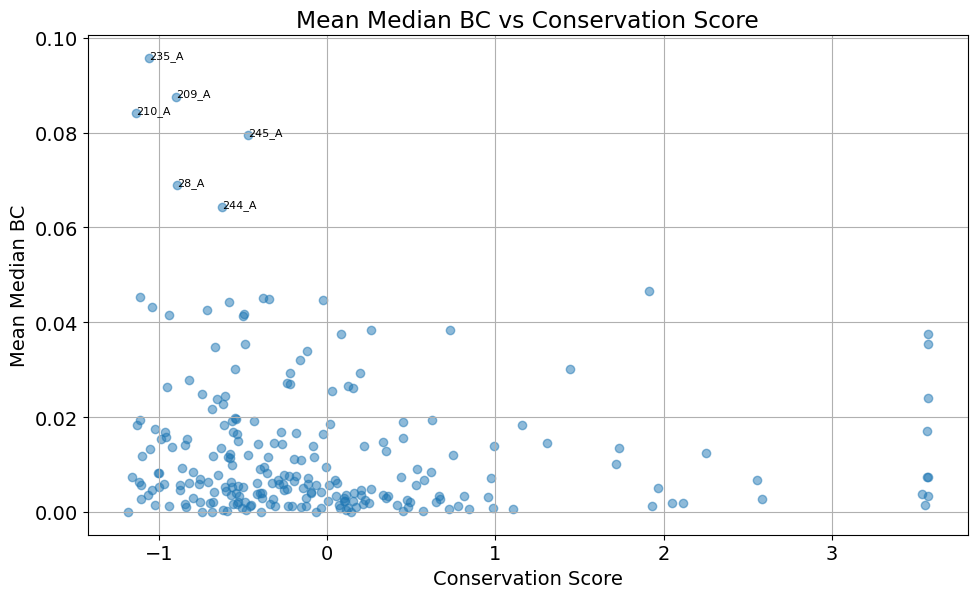

In [47]:
# Plot mean_median_bc vs cons_score
plt.figure(figsize=(10, 6))
# Increase font size to make it more readable
plt.rcParams.update({'font.size': 14})
plt.scatter(df_bc_sig_aff_resids[df_bc_sig_aff_resids['Residue_id'].str.contains('_A')]['cons_score'], 
            df_bc_sig_aff_resids[df_bc_sig_aff_resids['Residue_id'].str.contains('_A')]['mean_median_bc'], alpha=0.5)
plt.xlabel('Conservation Score')
plt.ylabel('Mean Median BC')
# Annotate the points with their residue IDs, but only for those with mean BC above 0.06
for i, row in df_bc_sig_aff_resids[df_bc_sig_aff_resids['Residue_id'].str.contains('_A')].iterrows():
    if row['mean_median_bc'] > 0.06:
        plt.annotate(row['Residue_id'], (row['cons_score'], row['mean_median_bc']), fontsize=8)
plt.grid()
plt.tight_layout()
plt.title('Mean Median BC vs Conservation Score')

### Visualize conservation vs network centrality relationship

In [144]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_3utq_pf',ascending=False, inplace=True)
top10_bc_aff_3utq = df_bc_sig_aff_resids[:10]
top10_bc_aff_3utq

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
168       64_B        0.182151         0.043241         0.059742   
9         27_A        0.045115         0.042899        -0.084879   
4          5_A        0.027224         0.022111         0.002408   
188       31_A        0.044813         0.019177         0.006126   
295       33_B        0.016053         0.010388         0.010595   
181      100_B        0.024045         0.010350         0.026399   
127      244_A        0.064223         0.010104        -0.077239   
179       96_B        0.044205         0.008857         0.000263   
38       101_A        0.006282         0.007803        -0.008318   
240       63_B        0.073151         0.007379         0.000970   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
168         0.022860            0.235720            0.298793   
9          -0.083871            0.330082          -38.814617   
4          -0.005756            0.513257            0.102988   
188         0.050432            0.494961            0.238414   
295        -0.001381            0.521828            0.526765   
181        -0.010081            0.405781            0.635288   
127        -0.072635            0.083562           -2.300558   
179         0.000309            0.177422            0.006368   
38         -0.008532            0.456300           -8.489691   
240        -0.002196            0.094030            0.013453   

     pt_diff_bc_5c0f_pf  
168            0.140190  
9            -26.252718  
4             -0.378357  
188            0.720460  
295           -0.169710  
181           -1.986790  
127           -1.902544  
179            0.007473  
38           -11.134383  
240           -0.031865

### Identify top residues with increased centrality upon peptide binding

In [156]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_5n1y_pf',ascending=False, inplace=True)
top10_bc_aff_5n1y = df_bc_sig_aff_resids[:10]
top10_bc_aff_5n1y

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
223      210_A        0.084164         0.000264         0.128271   
119      235_A        0.095692        -0.004055         0.103902   
268      245_A        0.079498         0.001159         0.098618   
168       64_B        0.182151         0.043241         0.059742   
10        28_A        0.068979         0.004103         0.059413   
95       203_A        0.045367        -0.004684         0.057570   
189       32_A        0.044777        -0.000578         0.050250   
96       205_A        0.041625         0.001207         0.046358   
46       117_A        0.041397        -0.002830         0.042116   
291      182_A        0.031988        -0.000317         0.040536   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
223         0.108277            0.048076            0.960848   
119         0.121644           -0.227730            0.826167   
268         0.110985            0.111395            0.914298   
168         0.022860            0.235720            0.298793   
10          0.061673            0.130874            0.685571   
95          0.048539           -0.681355            0.832800   
189         0.038411           -0.038968            0.765239   
96          0.049254            0.114347            0.832134   
46          0.047082           -0.289407            0.769614   
291         0.041116           -0.069486            0.892608   

     pt_diff_bc_5c0f_pf        p_value  
223            0.953952  1.294084e-291  
119            0.847658  2.249479e-139  
268            0.923114  1.453574e-167  
168            0.140190   6.132575e-32  
10             0.693562   6.786716e-97  
95             0.807672  2.304552e-177  
189            0.713605   4.637470e-57  
96             0.840429  2.603455e-129  
46             0.788780  1.333285e-203  
291            0.893962  1.567167e-158

In [157]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_5c0f_pf',ascending=False, inplace=True)
top10_bc_aff_5c0f = df_bc_sig_aff_resids[:10]
top10_bc_aff_5c0f

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
119      235_A        0.095692        -0.004055         0.103902   
268      245_A        0.079498         0.001159         0.098618   
223      210_A        0.084164         0.000264         0.128271   
10        28_A        0.068979         0.004103         0.059413   
188       31_A        0.044813         0.019177         0.006126   
96       205_A        0.041625         0.001207         0.046358   
95       203_A        0.045367        -0.004684         0.057570   
289      100_A        0.027915        -0.000890         0.032790   
46       117_A        0.041397        -0.002830         0.042116   
7         24_A        0.030123         0.001012         0.035969   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
119         0.121644           -0.227730            0.826167   
268         0.110985            0.111395            0.914298   
223         0.108277            0.048076            0.960848   
10          0.061673            0.130874            0.685571   
188         0.050432            0.494961            0.238414   
96          0.049254            0.114347            0.832134   
95          0.048539           -0.681355            0.832800   
289         0.047324           -1.443928            0.956055   
46          0.047082           -0.289407            0.769614   
7           0.041724            0.206439            0.902442   

     pt_diff_bc_5c0f_pf        p_value  
119            0.847658  2.249479e-139  
268            0.923114  1.453574e-167  
223            0.953952  1.294084e-291  
10             0.693562   6.786716e-97  
188            0.720460   1.989408e-24  
96             0.840429  2.603455e-129  
95             0.807672  2.304552e-177  
289            0.969135  3.836451e-280  
46             0.788780  1.333285e-203  
7              0.914752  7.859775e-191

<Axes: xlabel='Residue_id', ylabel='BC'>

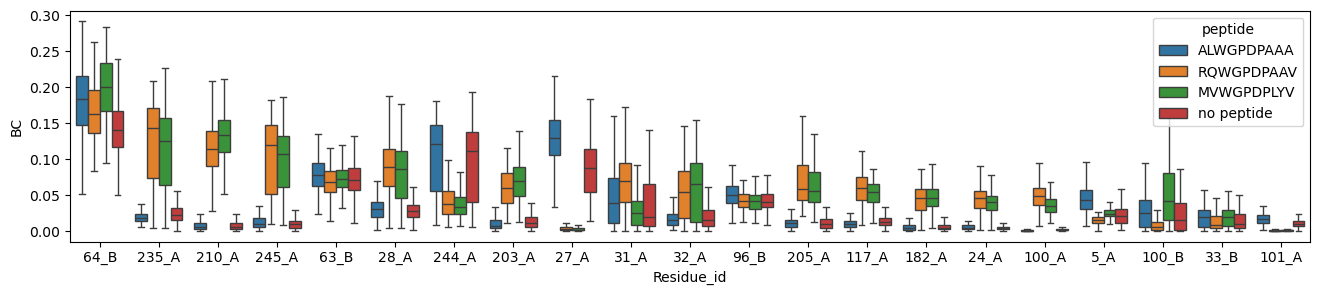

In [147]:
top10_bc = pd.concat([top10_bc_aff_3utq, top10_bc_aff_5n1y, top10_bc_aff_5c0f],ignore_index=True)
top10_bc.sort_values(by='mean_median_bc',ascending=False,inplace=True)
(fig,ax) = plt.subplots(nrows=1,ncols=1,figsize=(16,3))
df_2plot = df_bc_equil_cons_resids[df_bc_equil_cons_resids['Residue_id'].isin(top10_bc['Residue_id'].values)]
order = top10_bc['Residue_id'].values
sns.boxplot(df_2plot,x='Residue_id',y='BC',hue='peptide', ax= ax, order=order,showfliers=False)

In [158]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_3utq_pf',ascending=True, inplace=True)
bottom10_bc_aff_3utq = df_bc_sig_aff_resids[:10]
bottom10_bc_aff_3utq

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
5          7_A        0.029238        -0.022486        -0.017965   
118      234_A        0.042674        -0.019224        -0.138788   
183        9_A        0.017138        -0.017076        -0.035268   
166       61_B        0.077686        -0.012083        -0.010938   
164       54_B        0.025517        -0.011748        -0.009962   
267      241_A        0.026270        -0.010883        -0.058888   
169       65_B        0.093996        -0.010212        -0.008092   
215      181_A        0.024823        -0.010187        -0.029974   
280       12_A        0.005535        -0.010150        -0.005590   
11        30_A        0.030209        -0.009989        -0.054517   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
5           0.018430           -1.595672           -0.965128   
118        -0.137505           -0.157633          -58.042910   
183        -0.027410           -0.640816           -4.171687   
166        -0.007134           -0.159712           -0.142418   
164        -0.012744           -0.465179           -0.368414   
267        -0.059306           -0.186311           -5.658480   
169        -0.007747           -0.110441           -0.085546   
215        -0.033263           -0.260477           -1.551116   
280        -0.008769           -2.856027           -0.688819   
11         -0.061296           -0.160714           -3.093002   

     pt_diff_bc_5c0f_pf        p_value  
5              0.335043   2.696754e-78  
118          -37.421373  2.583621e-194  
183           -1.680275  1.053465e-151  
166           -0.088509   7.149962e-07  
164           -0.525365   6.294000e-11  
267           -5.937006  1.745512e-145  
169           -0.081610   3.653714e-03  
215           -2.074354   2.224194e-58  
280           -1.776852   1.517493e-64  
11            -5.651142   7.917171e-54

### Identify residues with decreased centrality upon peptide binding

In [159]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_5n1y_pf',ascending=True, inplace=True)
bottom10_bc_aff_5n1y = df_bc_sig_aff_resids[:10]
bottom10_bc_aff_5n1y

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
118      234_A        0.042674        -0.019224        -0.138788   
9         27_A        0.045115         0.042899        -0.084879   
127      244_A        0.064223         0.010104        -0.077239   
267      241_A        0.026270        -0.010883        -0.058888   
11        30_A        0.030209        -0.009989        -0.054517   
203      113_A        0.016380        -0.002471        -0.046473   
258      116_A        0.035460         0.002892        -0.040834   
221      202_A        0.044307         0.000628        -0.035935   
183        9_A        0.017138        -0.017076        -0.035268   
246       25_A        0.013464        -0.008608        -0.035165   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
118        -0.137505           -0.157633          -58.042910   
9          -0.083871            0.330082          -38.814617   
127        -0.072635            0.083562           -2.300558   
267        -0.059306           -0.186311           -5.658480   
11         -0.061296           -0.160714           -3.093002   
203        -0.045376           -0.054495          -34.489505   
258        -0.035054            0.046139           -2.153871   
221        -0.033668            0.009247           -1.145741   
183        -0.027410           -0.640816           -4.171687   
246        -0.033938           -0.279847           -8.365856   

     pt_diff_bc_5c0f_pf        p_value  
118          -37.421373  2.583621e-194  
9            -26.252718  4.713842e-269  
127           -1.902544   3.042446e-70  
267           -5.937006  1.745512e-145  
11            -5.651142   7.917171e-54  
203          -18.569864  8.292409e-307  
258           -1.416991  4.995425e-114  
221           -1.001142   4.169669e-89  
183           -1.680275  1.053465e-151  
246           -6.250006  1.498076e-182

In [160]:
df_bc_sig_aff_resids.sort_values(by='diff_bc_5c0f_pf',ascending=True, inplace=True)
bottom10_bc_aff_5c0f = df_bc_sig_aff_resids[:10]
bottom10_bc_aff_5c0f

Residue_id  mean_median_bc  diff_bc_3utq_pf  diff_bc_5n1y_pf  \
118      234_A        0.042674        -0.019224        -0.138788   
9         27_A        0.045115         0.042899        -0.084879   
127      244_A        0.064223         0.010104        -0.077239   
11        30_A        0.030209        -0.009989        -0.054517   
267      241_A        0.026270        -0.010883        -0.058888   
203      113_A        0.016380        -0.002471        -0.046473   
258      116_A        0.035460         0.002892        -0.040834   
213      179_A        0.015347        -0.005303        -0.033036   
246       25_A        0.013464        -0.008608        -0.035165   
221      202_A        0.044307         0.000628        -0.035935   

     diff_bc_5c0f_pf  pt_diff_bc_3utq_pf  pt_diff_bc_5n1y_pf  \
118        -0.137505           -0.157633          -58.042910   
9          -0.083871            0.330082          -38.814617   
127        -0.072635            0.083562           -2.300558   
11         -0.061296           -0.160714           -3.093002   
267        -0.059306           -0.186311           -5.658480   
203        -0.045376           -0.054495          -34.489505   
258        -0.035054            0.046139           -2.153871   
213        -0.034110           -0.155085           -5.113273   
246        -0.033938           -0.279847           -8.365856   
221        -0.033668            0.009247           -1.145741   

     pt_diff_bc_5c0f_pf        p_value  
118          -37.421373  2.583621e-194  
9            -26.252718  4.713842e-269  
127           -1.902544   3.042446e-70  
11            -5.651142   7.917171e-54  
267           -5.937006  1.745512e-145  
203          -18.569864  8.292409e-307  
258           -1.416991  4.995425e-114  
213           -6.332365   5.893005e-93  
246           -6.250006  1.498076e-182  
221           -1.001142   4.169669e-89

<Axes: xlabel='Residue_id', ylabel='BC'>

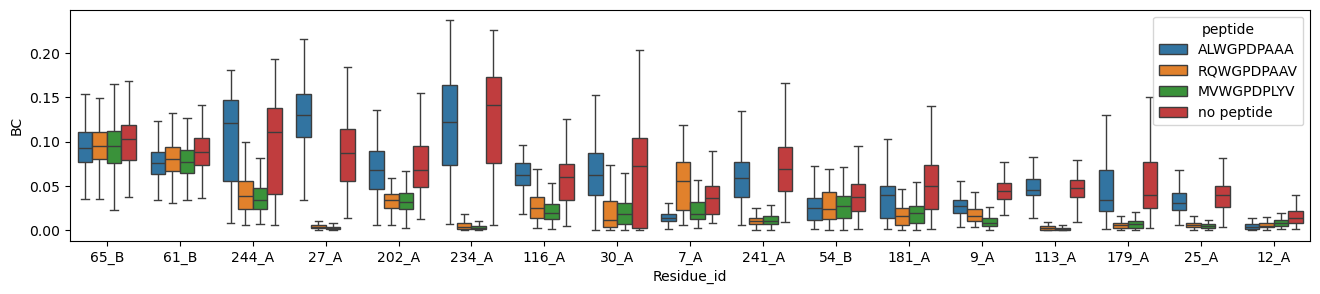

In [161]:
bottom10_bc = pd.concat([bottom10_bc_aff_3utq, bottom10_bc_aff_5n1y, bottom10_bc_aff_5c0f],ignore_index=True)
bottom10_bc.sort_values(by='mean_median_bc',ascending=False,inplace=True)
(fig,ax) = plt.subplots(nrows=1,ncols=1,figsize=(16,3))
df_2plot = df_bc_equil_cons_resids[df_bc_equil_cons_resids['Residue_id'].isin(bottom10_bc['Residue_id'].values)]
order = bottom10_bc['Residue_id'].values
sns.boxplot(df_2plot,x='Residue_id',y='BC',hue='peptide', ax= ax, order=order,showfliers=False)

## 10. Focused Analysis Around Polymorphic Positions
Analysis of interaction energies around polymorphic positions

In [108]:
def analyze_polymorphic_residue_interactions(df, residue_id, peptide_filter=None, title_suffix="", figsize=(10, 6)):
    # Determine available frame columns dynamically
    potential_frame_cols = [str(i) for i in range(1000)]
    available_frame_cols = [col for col in potential_frame_cols if col in df.columns]
    
    # Apply peptide filter if specified
    if peptide_filter == 'loaded':
        df_filtered = df[df['peptide'].notna()].copy()
        filter_desc = "peptide-loaded systems"
    elif peptide_filter == 'free':
        df_filtered = df[df['peptide'].isna()].copy()
        filter_desc = "peptide-free systems"
    else:
        df_filtered = df.copy()
        filter_desc = "all systems"
    
    # Get interactions involving the specified residue
    df_residue = df_filtered.query(f"resnum_chain1 == '{residue_id}' or resnum_chain2 == '{residue_id}'")
    
    if len(df_residue) == 0:
        print(f"Warning: No interactions found involving residue {residue_id}")
        return {'filtered_df': df_residue, 'unique_pairs': [], 'pair_counts': {}}
    
    print(f"Found {len(df_residue)} interactions involving residue {residue_id} in {filter_desc}")
    
    # Count pairs per allele
    pair_counts = {}
    unique_pairs = df_residue['resnum_chain12'].unique()
    
    # Plot KDE for each unique pair
    for resnum_chain12 in unique_pairs:
        df_pair = df_residue[df_residue['resnum_chain12'] == resnum_chain12]
        
        if len(df_pair) == 0:
            continue
            
        plt.figure(figsize=figsize)
        alleles_plotted = []
        
        for allele in df_pair['allele'].unique():
            df_allele = df_pair[df_pair['allele'] == allele]
            
            if len(df_allele) == 0:
                continue
                
            interaction_energies = df_allele[available_frame_cols].values.flatten()
            interaction_energies = interaction_energies[~np.isnan(interaction_energies)]
            
            if len(interaction_energies) == 0:
                continue
                
            sns.kdeplot(interaction_energies, label=allele, fill=True, alpha=0.7)
            alleles_plotted.append(allele)
            
            if allele not in pair_counts:
                pair_counts[allele] = 0
            pair_counts[allele] += 1
        
        if alleles_plotted:
            plt.title(f'Interaction energies for {resnum_chain12} in {filter_desc}{title_suffix}')
            plt.xlabel('Interaction Energy (kJ/mol)')
            plt.ylabel('Density')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            plt.close()
    
    print(f"\nSummary for residue {residue_id}:")
    print(f"Total unique interaction pairs: {len(unique_pairs)}")
    print(f"Pairs per allele: {pair_counts}")
    
    return {'filtered_df': df_residue, 'unique_pairs': list(unique_pairs), 'pair_counts': pair_counts}

In [ ]:
# Analyze residue 74M in peptide-free systems for comparison
results_74M_free = analyze_polymorphic_residue_interactions(
    df_cons_pairs, 
    '74M', 
    peptide_filter='free',
    title_suffix=" (Polymorphic Position - Free)"
)

Unnamed: 0     pair  repeat allele peptide  \
409          1025  172-109       4  B3901     NaN   
19347        1139  172-109       1  B3906     NaN   
20631         994  172-109       2  B3906     NaN   
22015        1110  172-109       3  B3906     NaN   
23320        1023  172-109       4  B3906     NaN   
28711        1038  172-109       1  B3801     NaN   
30028        1038  172-109       2  B3801     NaN   
31347        1008  172-109       3  B3801     NaN   
32652         978  172-109       4  B3801     NaN   
48844        1055  172-109       1  B3901     NaN   
50174         965  172-109       2  B3901     NaN   
51598        1175  172-109       3  B3901     NaN   

                                            dry_pdb_file system         0  \
409    /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3901 -0.260898   
19347  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3906  0.547915   
20631  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3906  0.547915   
22015  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3906  1.026455   
23320  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3906  0.377634   
28711  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3801  0.002463   
30028  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3801 -0.009974   
31347  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3801 -1.339773   
32652  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3801 -1.333236   
48844  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3901 -0.353540   
50174  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3901 -0.458939   
51598  /mnt/MORIA/experiments/hla_b39/2022_10_14_bioe...  B3901 -0.125762   

              1         2  ...        238        239  resnum1  chain1  \
409   -1.582742 -1.148995  ...  -0.678358  -1.388044     74.0       M   
19347 -1.008802 -1.175824  ...  -0.002243  -0.002333     74.0       M   
20631 -1.008802 -1.175824  ...  -0.002243  -0.002333     74.0       M   
22015 -0.756770 -1.023385  ...  -0.452239  -0.006501     74.0       M   
23320 -0.895697 -0.844904  ...  -0.011337  -0.002170     74.0       M   
28711 -0.302974 -0.097552  ...  -0.545160  12.573301     74.0       M   
30028 -0.861232 -0.125941  ...  88.574834  -0.350098     74.0       M   
31347 -0.540156 -0.372480  ...  -0.452054  -0.348359     74.0       M   
32652  8.531792 -0.539806  ...  -0.047870  -0.072978     74.0       M   
48844 -1.204247 -1.310989  ...  -0.674671  -0.282218     74.0       M   
50174 -0.455772 -1.229467  ...  -0.963643  -0.973955     74.0       M   
51598 -1.063211 -1.104655  ...  -1.220425  -0.853081     74.0       M   

       resnum2  chain2  resnum_chain1  resnum_chain2  resnum_chain12   p_value  
409       11.0       M            74M            11M         11M-74M  0.301498  
19347     11.0       M            74M            11M         11M-74M  0.301498  
20631     11.0       M            74M            11M         11M-74M  0.301498  
22015     11.0       M            74M            11M         11M-74M  0.301498  
23320     11.0       M            74M            11M         11M-74M  0.301498  
28711     11.0       M            74M            11M         11M-74M  0.301498  
30028     11.0       M            74M            11M         11M-74M  0.301498  
31347     11.0       M            74M            11M         11M-74M  0.301498  
32652     11.0       M            74M            11M         11M-74M  0.301498  
48844     11.0       M            74M            11M         11M-74M  0.301498  
50174     11.0       M            74M            11M         11M-74M  0.301498  
51598     11.0       M            74M            11M         11M-74M  0.301498  

[12 rows x 255 columns]

Found 35 interactions involving residue 74M in peptide-loaded systems


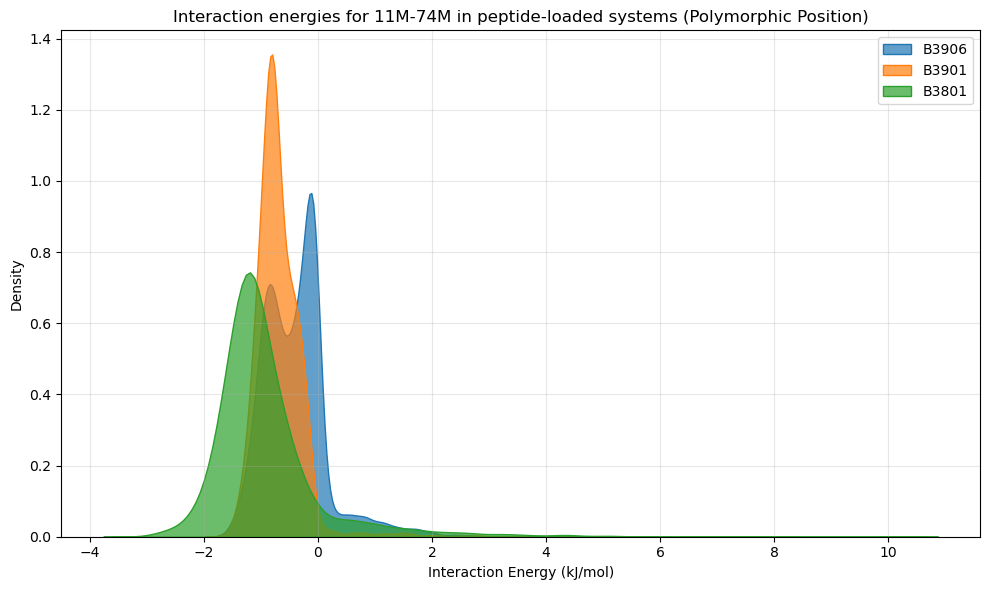


Summary for residue 74M:
Total unique interaction pairs: 1
Pairs per allele: {'B3906': 1, 'B3901': 1, 'B3801': 1}


In [109]:
# Analyze residue 74M in peptide-loaded systems
results_74M = analyze_polymorphic_residue_interactions(
    df_cons_pairs, 
    '74M', 
    peptide_filter='loaded',
    title_suffix=" (Polymorphic Position)"
)

Found 93 interactions involving residue 77M in peptide-loaded systems


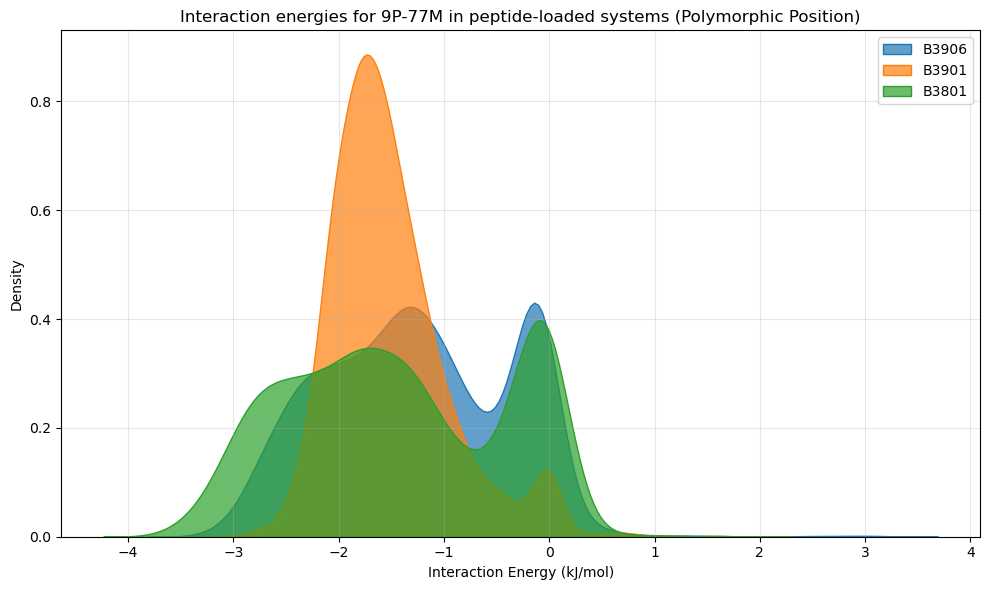

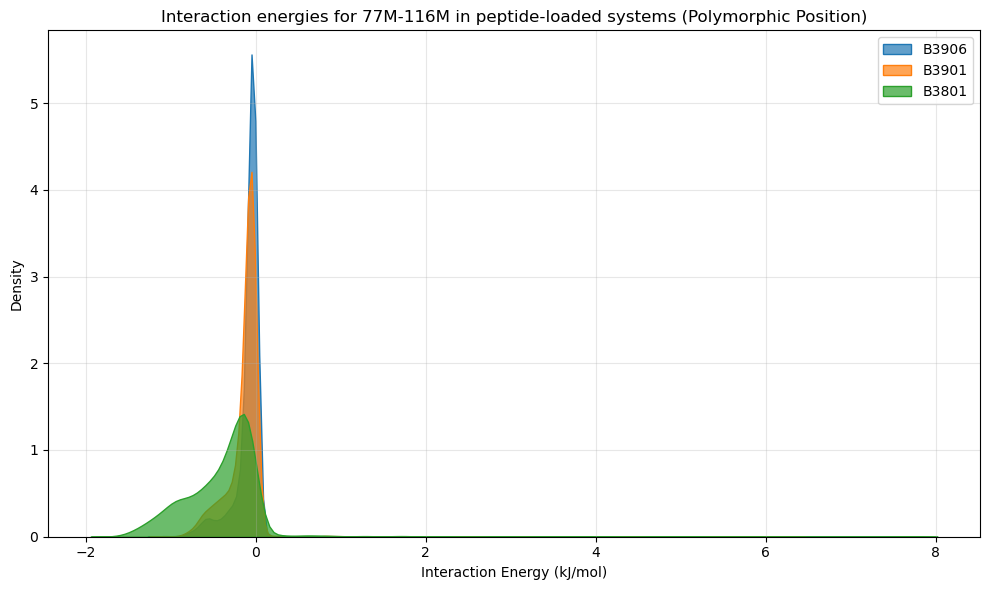

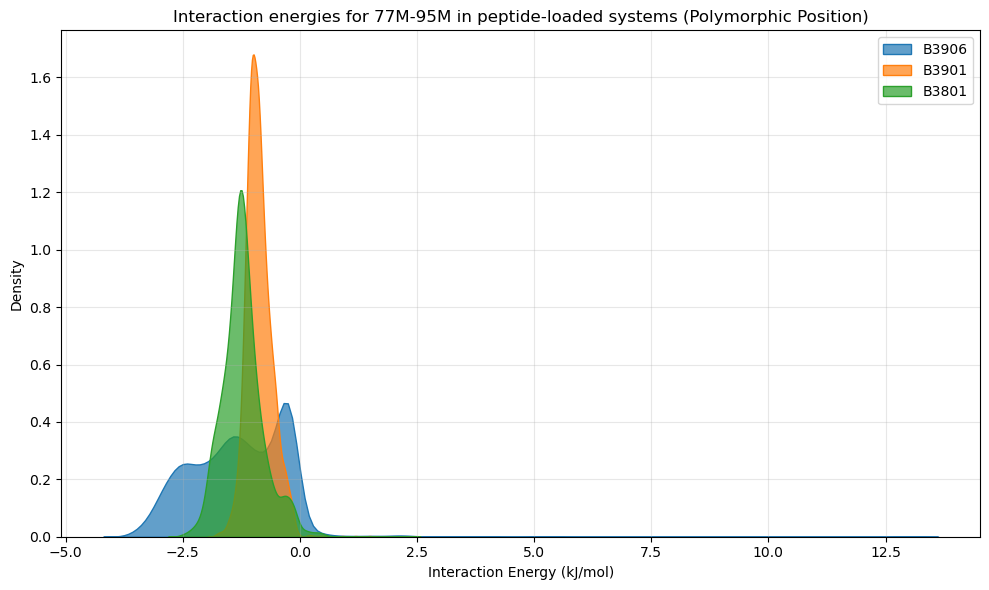


Summary for residue 77M:
Total unique interaction pairs: 3
Pairs per allele: {'B3906': 3, 'B3901': 3, 'B3801': 3}


In [110]:
# Analyze residue 74M in peptide-loaded systems
results_77M = analyze_polymorphic_residue_interactions(
    df_cons_pairs, 
    '77M', 
    peptide_filter='loaded',
    title_suffix=" (Polymorphic Position)"
)

Found 70 interactions involving residue 80M in peptide-loaded systems


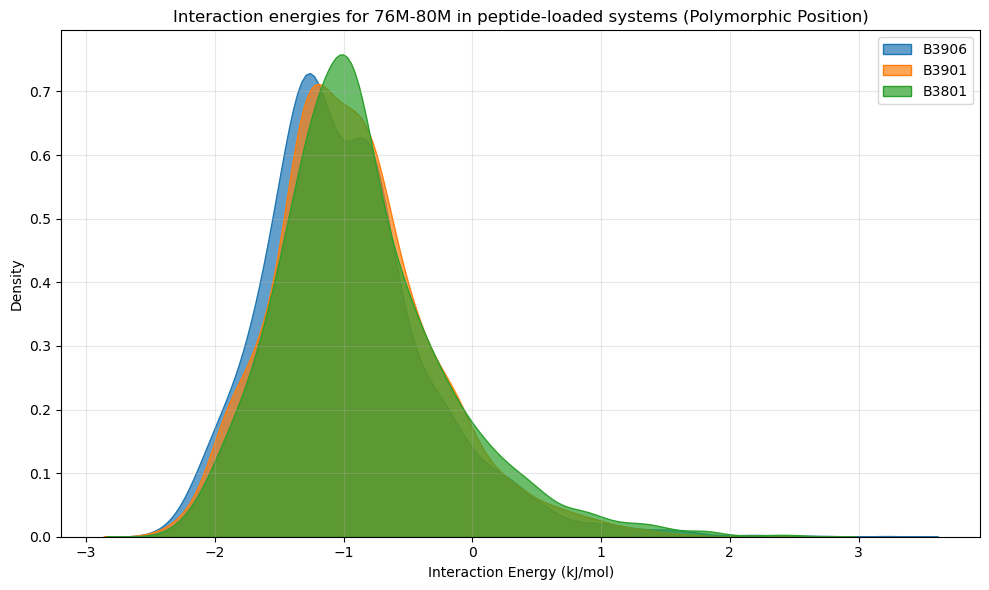

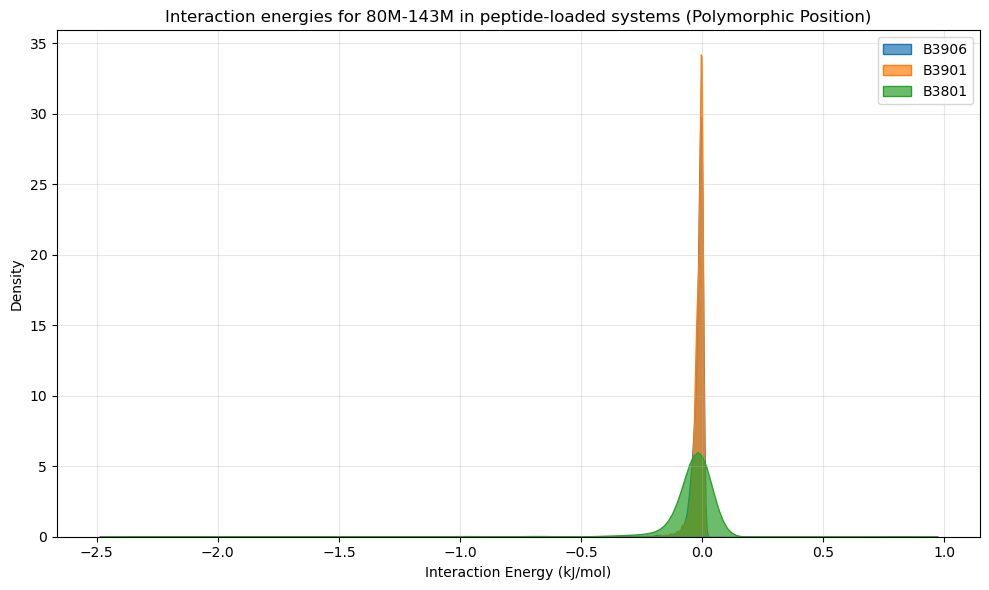


Summary for residue 80M:
Total unique interaction pairs: 2
Pairs per allele: {'B3906': 2, 'B3901': 2, 'B3801': 2}


In [112]:
# Analyze residue 80M in peptide-loaded systems
results_80M = analyze_polymorphic_residue_interactions(
    df_cons_pairs, 
    '80M', 
    peptide_filter='loaded',
    title_suffix=" (Polymorphic Position)"
)

Found 152 interactions involving residue 81M in peptide-loaded systems


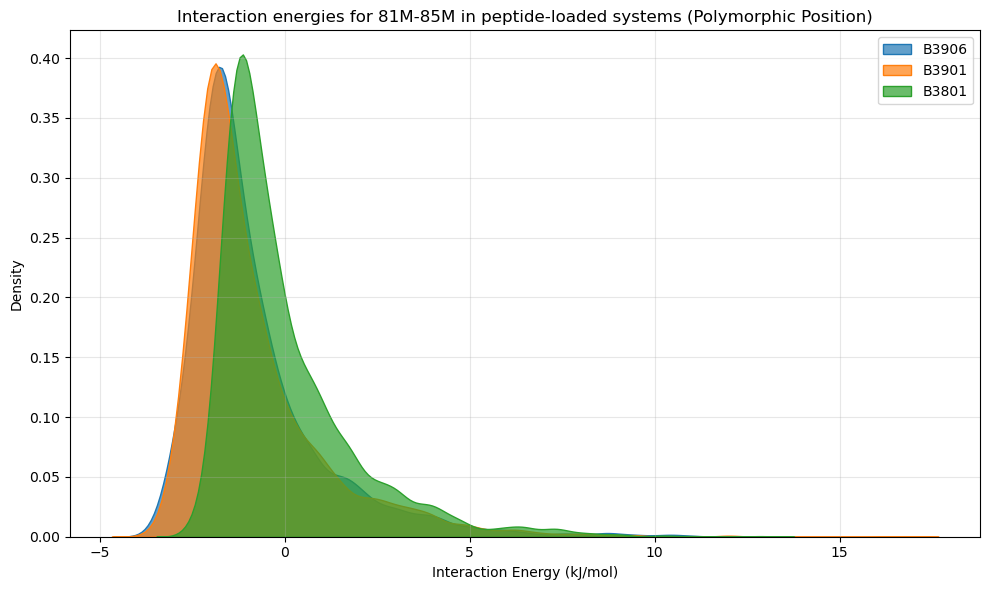

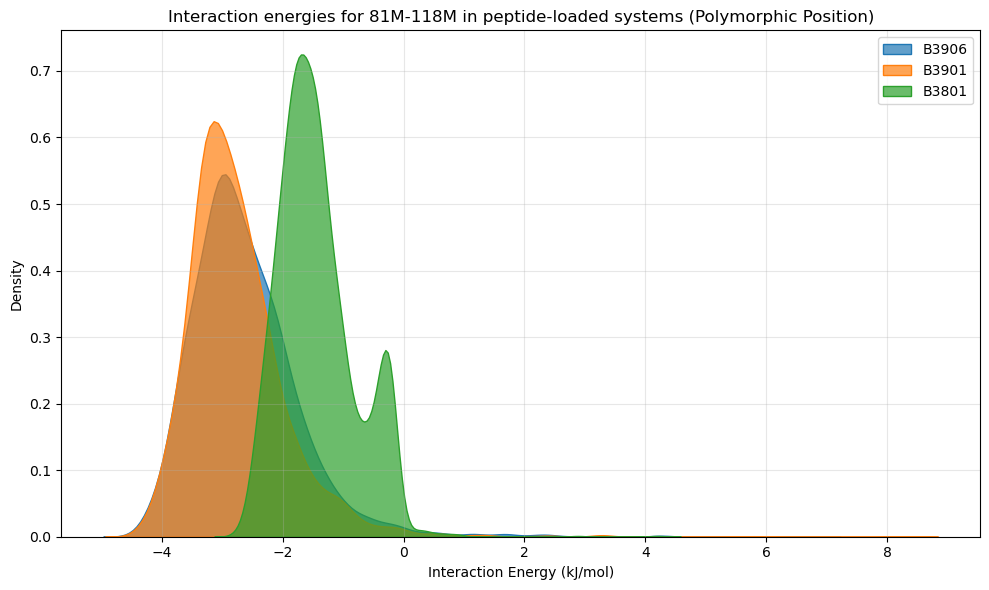

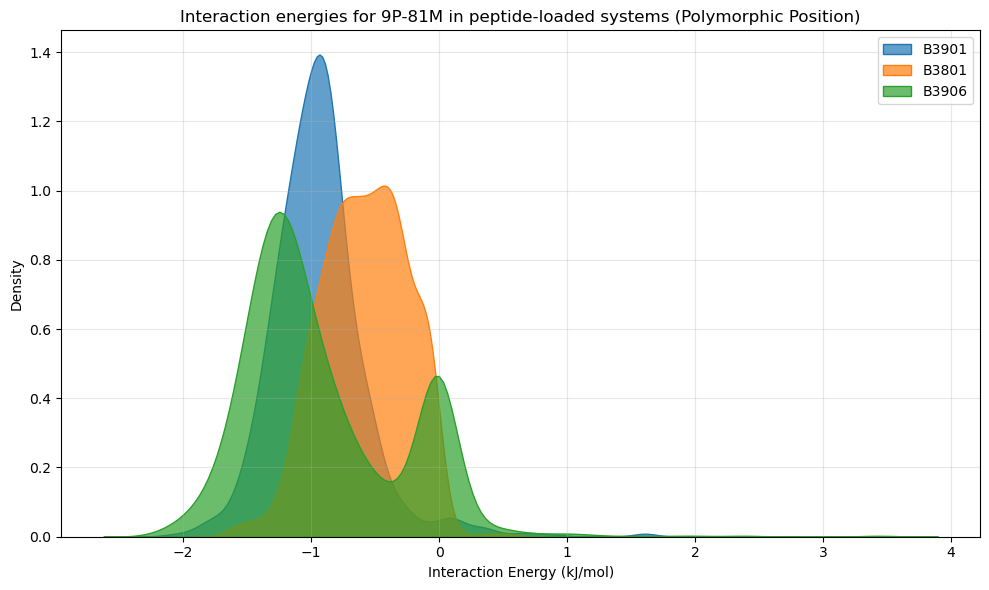


Summary for residue 81M:
Total unique interaction pairs: 3
Pairs per allele: {'B3906': 3, 'B3901': 3, 'B3801': 3}


In [113]:
# Analyze residue 81M in peptide-loaded systems
results_81M = analyze_polymorphic_residue_interactions(
    df_cons_pairs, 
    '81M', 
    peptide_filter='loaded',
    title_suffix=" (Polymorphic Position)"
)

Found 385 interactions involving residue 82M in peptide-loaded systems


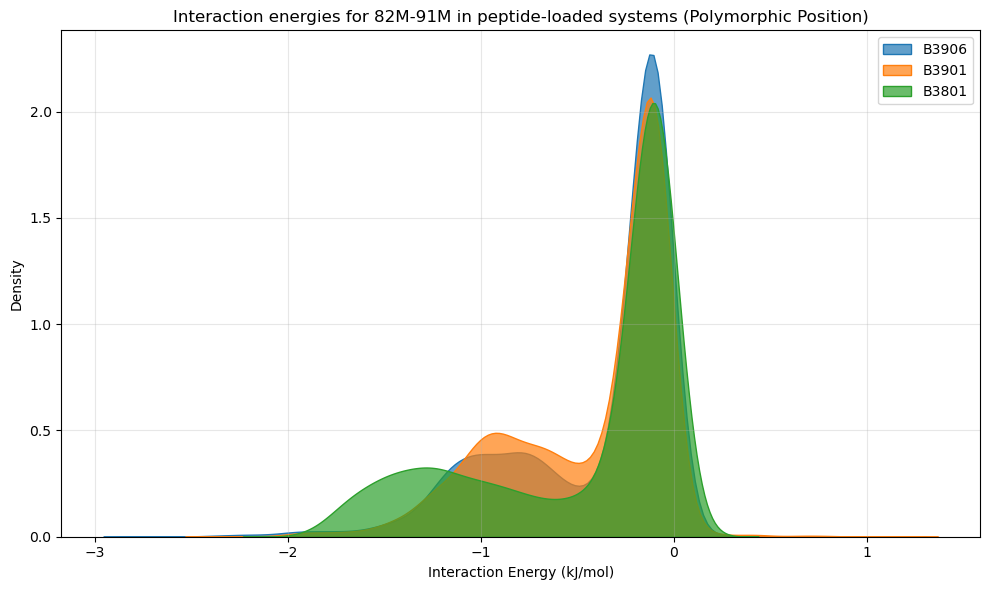

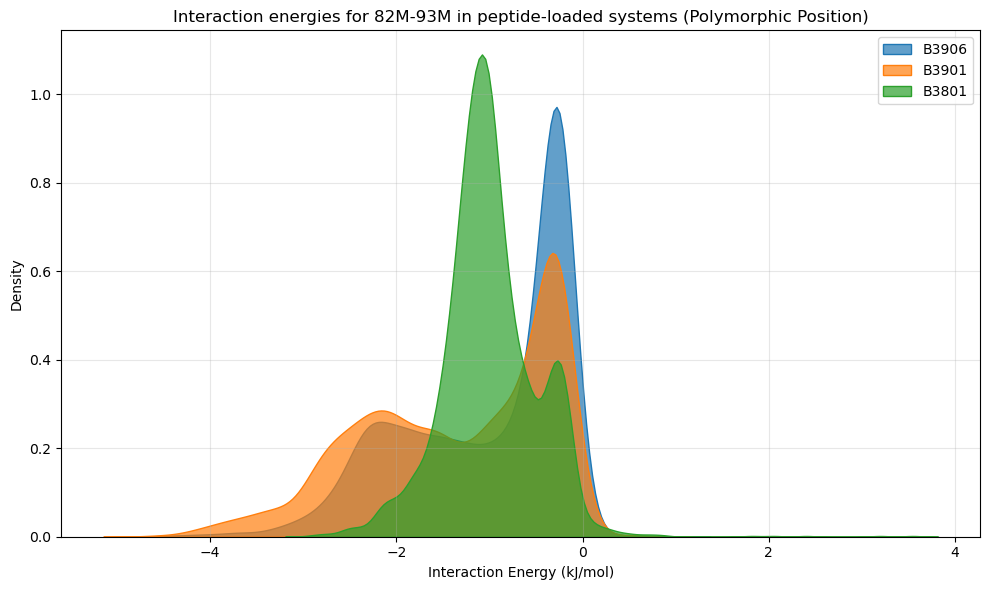

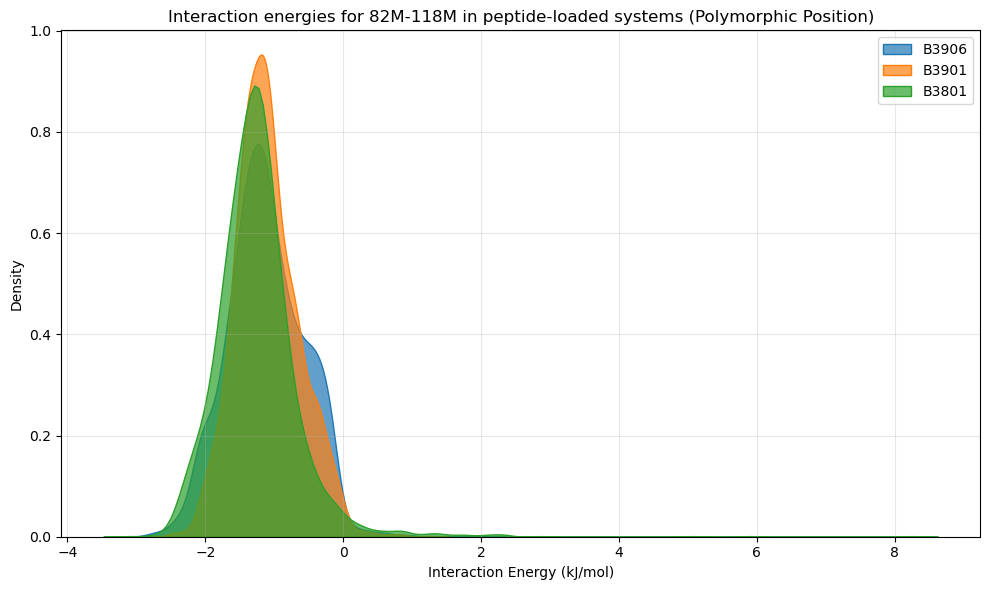

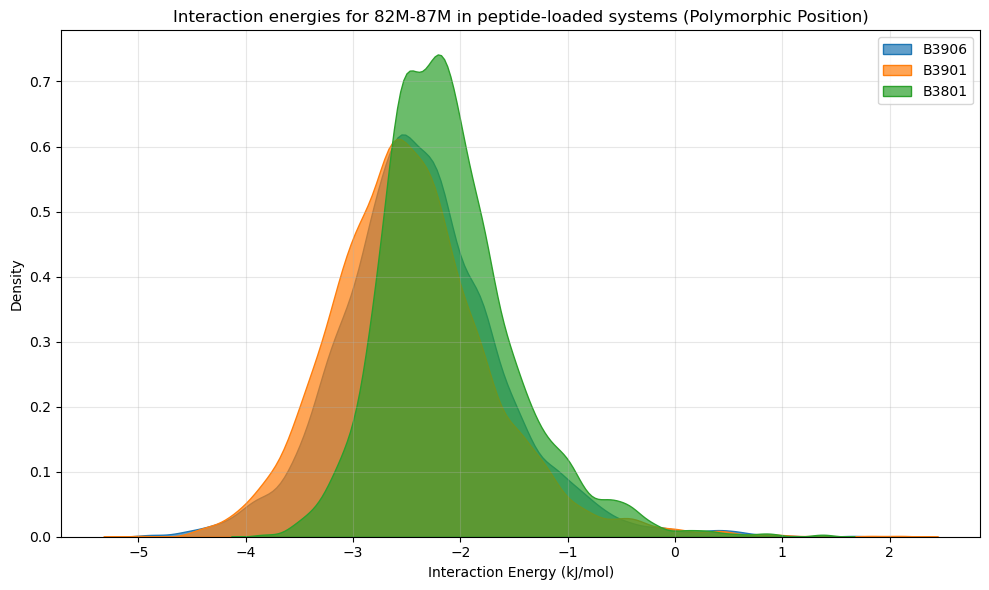

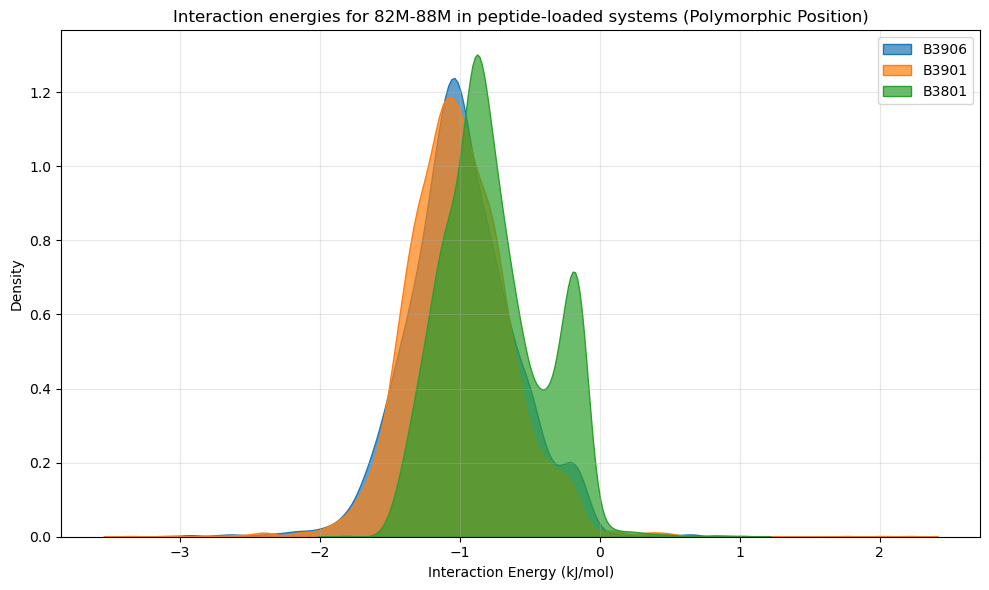

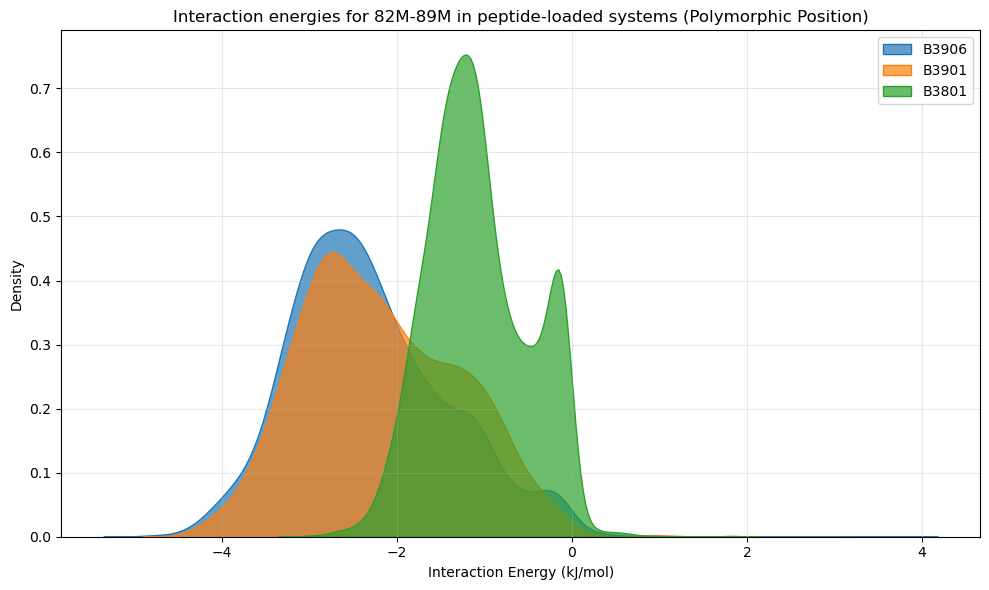


Summary for residue 82M:
Total unique interaction pairs: 6
Pairs per allele: {'B3906': 6, 'B3901': 6, 'B3801': 6}


In [114]:
# Analyze residue 82M in peptide-loaded systems
results_82M = analyze_polymorphic_residue_interactions(
    df_cons_pairs, 
    '82M', 
    peptide_filter='loaded',
    title_suffix=" (Polymorphic Position)"
)

In [115]:
# Analyze residue 83M in peptide-loaded systems
results_83M = analyze_polymorphic_residue_interactions(
    df_cons_pairs, 
    '83M', 
    peptide_filter='loaded',
    title_suffix=" (Polymorphic Position)"
)

Found 595 interactions involving residue 95M in peptide-loaded systems


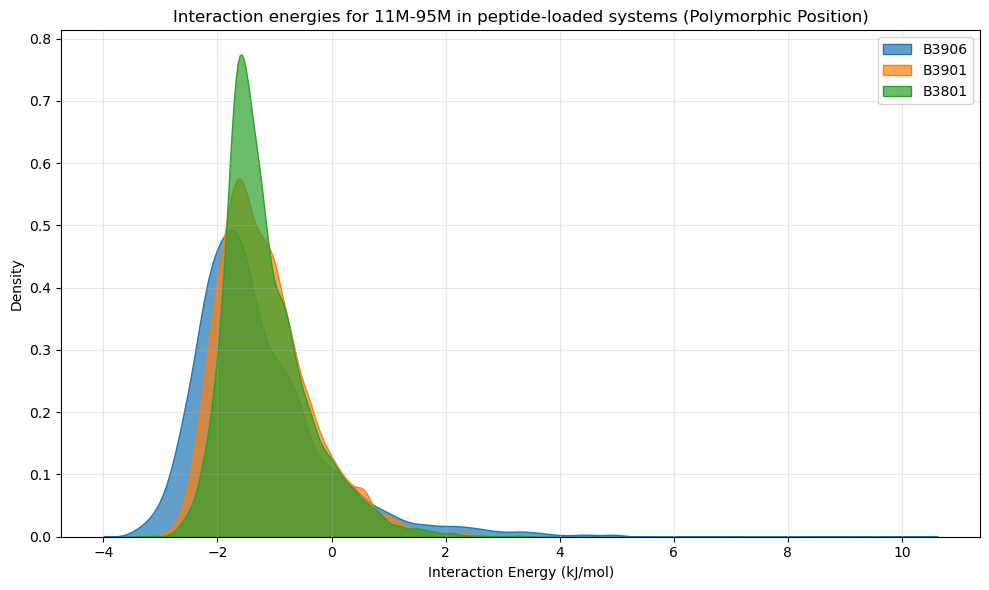

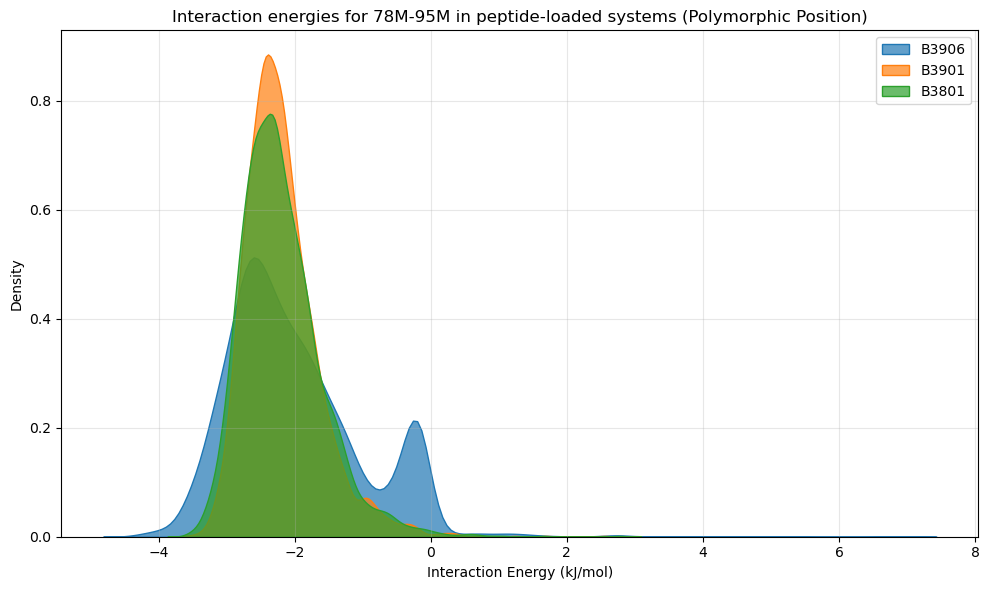

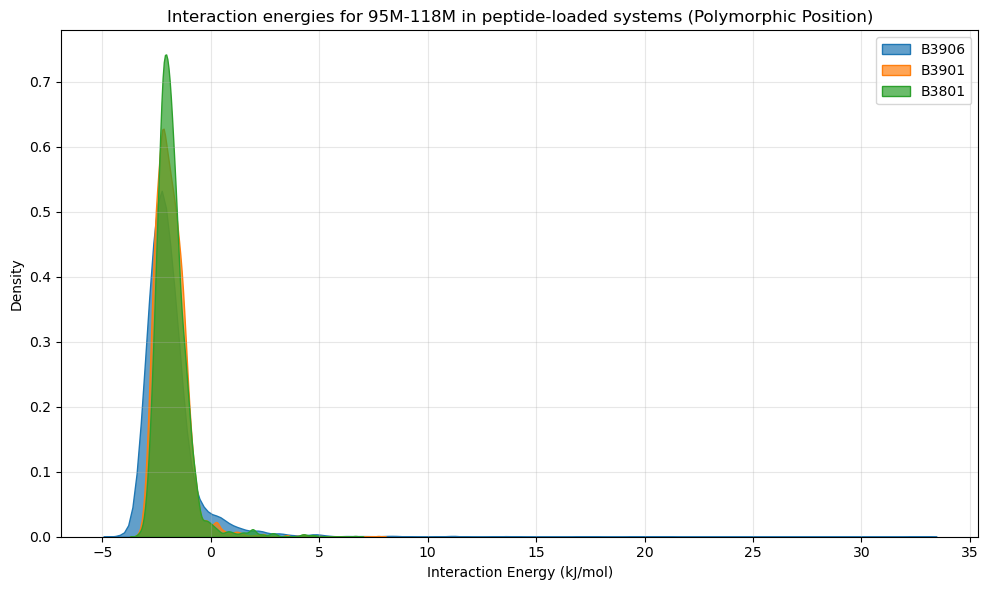

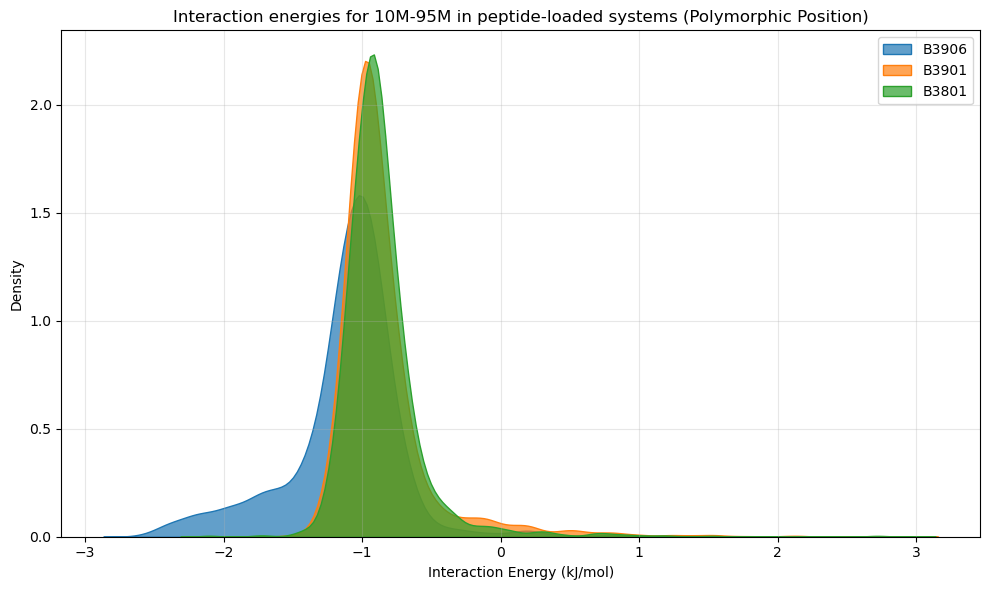

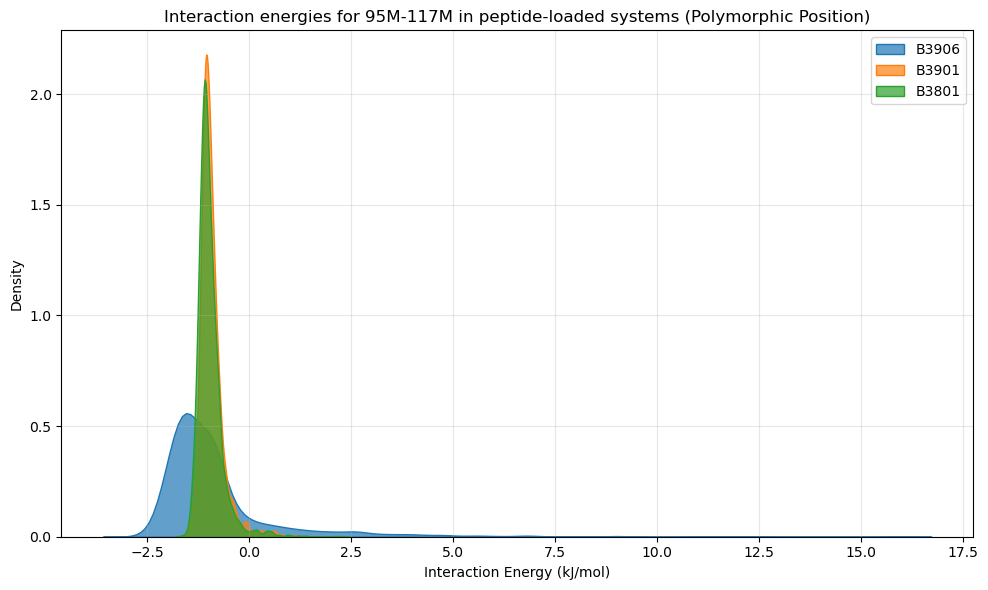

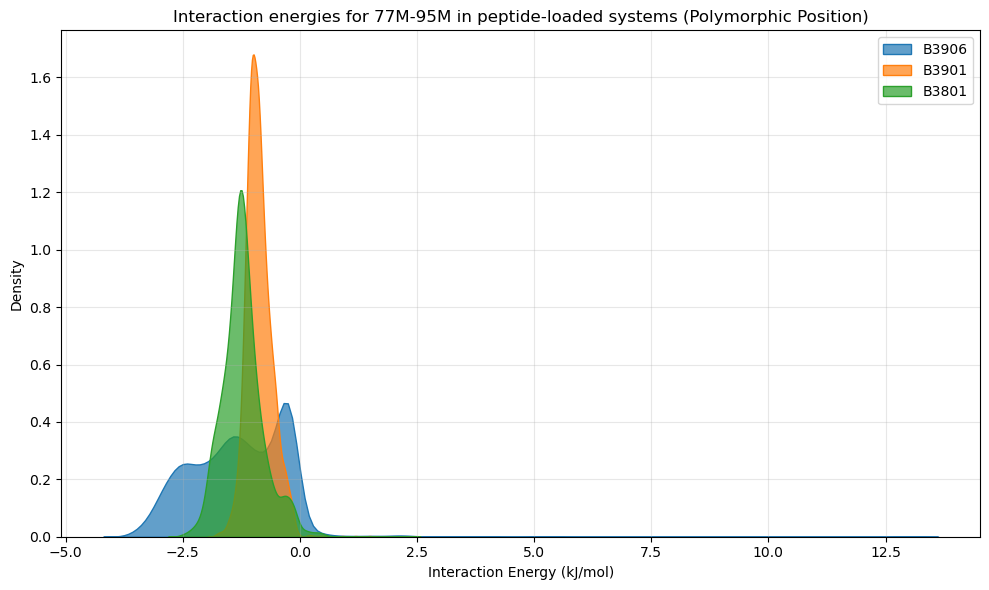


Summary for residue 95M:
Total unique interaction pairs: 6
Pairs per allele: {'B3906': 6, 'B3901': 6, 'B3801': 6}


In [116]:
# Analyze residue 95M in peptide-loaded systems
results_95M = analyze_polymorphic_residue_interactions(
    df_cons_pairs, 
    '95M', 
    peptide_filter='loaded',
    title_suffix=" (Polymorphic Position)"
)